# Setting-up the environment

In [5]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import os
import duckdb

import random
import math
##Extras:
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from statsmodels.stats.power import TTestIndPower, tt_ind_solve_power
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.proportion import proportions_chisquare, confint_proportions_2indep
import datetime as dt
import sklearn
import statsmodels.formula.api as smf
from patsy import dmatrices


# Importing dataset
 ### As stated on the PDF file, each row represents a LIKE or a DISLIKE event, given from a user to that specific video.

In [6]:
df = duckdb.read_parquet('C:\\JN\sample_data.parquet.gzip')
df=df.to_df()
df.head()

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_19840\1596601600.py:1: SyntaxWarning: invalid escape sequence '\s'
  df = duckdb.read_parquet('C:\\JN\sample_data.parquet.gzip')


,ACTION,TITLE,DESCRIPTION,CLIENT_OS,CHANNEL_TYPE,CREATED_AT,STREAM_URL,STREAM_AUTHOR,PLAYLIST_STREAM_PW,PLAYLIST_USERSTATS_AVG_MAVG,PLAYLIST_STREAM_USERSTATS_MAVG,DISTINCT_USERS,P_EXIT_USERS,STREAM_AGE_ON_PLAYLIST_CREATION,USER_AGE_UNTIL_PLAYLIST_CREATION,DURATION,IS_FAVORITE_CHANNEL,IS_FAVORITE_TAG
0,DISLIKE,This Car-Bike Hybrid Could Be the Future of Ci...,"It&rsquo;s safer than an e-bike, but even more...",roku,national,2022-07-01 22:52:44.320000-05:00,http://haystack.tv/id/eAkzbFgmc,amazelab,NaN,1.000000,NaN,12324.0,0.016310,15.0,744.0,76.567,0,0
1,DISLIKE,This Car-Bike Hybrid Could Be the Future of Ci...,"It&rsquo;s safer than an e-bike, but even more...",firetv,national,2022-07-01 23:39:46.149000-05:00,http://haystack.tv/id/eAkzbFgmc,amazelab,0.60,0.877527,0.96,12783.0,0.016897,16.0,38542.0,76.567,1,0
2,LIKE,This Car-Bike Hybrid Could Be the Future of Ci...,"It&rsquo;s safer than an e-bike, but even more...",android,national,2022-07-02 02:16:46.420000-05:00,http://haystack.tv/id/eAkzbFgmc,amazelab,0.60,0.357807,NaN,13947.0,0.017567,19.0,624.0,76.567,1,0
3,LIKE,This Car-Bike Hybrid Could Be the Future of Ci...,"It&rsquo;s safer than an e-bike, but even more...",roku,national,2022-07-02 03:03:13.056000-05:00,http://haystack.tv/id/eAkzbFgmc,amazelab,0.59,1.000000,NaN,15678.0,0.018051,20.0,976.0,76.567,0,0
4,DISLIKE,This Car-Bike Hybrid Could Be the Future of Ci...,"It&rsquo;s safer than an e-bike, but even more...",vizio,national,2022-07-02 03:38:23.181000-05:00,http://haystack.tv/id/eAkzbFgmc,amazelab,0.57,0.000000,NaN,16466.0,0.019070,20.0,14512.0,76.567,0,0


In [7]:
df.dtypes

ACTION                                                    object
TITLE                                                     object
DESCRIPTION                                               object
CLIENT_OS                                                 object
CHANNEL_TYPE                                              object
CREATED_AT                          datetime64[us, America/Lima]
STREAM_URL                                                object
STREAM_AUTHOR                                             object
PLAYLIST_STREAM_PW                                       float64
PLAYLIST_USERSTATS_AVG_MAVG                              float64
PLAYLIST_STREAM_USERSTATS_MAVG                           float64
DISTINCT_USERS                                           float64
P_EXIT_USERS                                             float64
STREAM_AGE_ON_PLAYLIST_CREATION                          float64
USER_AGE_UNTIL_PLAYLIST_CREATION                         float64
DURATION                 

In [8]:
df.isnull().mean()
#Playlist-related fields have the largest missing data rate of the whole dataframe (%). Rate of PLAYLIST_STREAM_USERSTATS_MAVG is a bit worrying (68pp).

ACTION                              0.000000
TITLE                               0.000000
DESCRIPTION                         0.000000
CLIENT_OS                           0.000000
CHANNEL_TYPE                        0.000000
CREATED_AT                          0.000000
STREAM_URL                          0.000000
STREAM_AUTHOR                       0.000000
PLAYLIST_STREAM_PW                  0.315339
PLAYLIST_USERSTATS_AVG_MAVG         0.261813
PLAYLIST_STREAM_USERSTATS_MAVG      0.677230
DISTINCT_USERS                      0.016908
P_EXIT_USERS                        0.016908
STREAM_AGE_ON_PLAYLIST_CREATION     0.000000
USER_AGE_UNTIL_PLAYLIST_CREATION    0.000000
DURATION                            0.000000
IS_FAVORITE_CHANNEL                 0.000000
IS_FAVORITE_TAG                     0.000000
dtype: float64

# EDA
 ## An EDA will be conducted in order to highlight any important finding 
   ### *Timeframe: 2022
   ### *All numeric values show a high volatility: large coefficient of variation
   ### *After generating the boxplots, it is clear that there is a notorious presence of outliers in each numeric variable (values that surpass the upper bound)
   ### *66% of events belong to ROKU devices, followed by FireTV (10%) and Android (7%).
   ### *After plotting the monthly evolution of LIKE RATE (LIKE/TOTAL EVENTS), a decreasing trend is observed (started on 62pp and ended on nearly 56pp), especially since Aug/22 and that might be connected to a higher quantity of videos posted, active channels and a greater videos-per-channel ratio (as shown in the other 3 line plots below).
   ### *After generating the bar charts to compare the LIKE RATE % between all possible values of the categorical features, it seems likely that the operative system and the fact that the channel or the video itself is marked as favorite by the user have an important effect on this metric.

In [9]:
df.columns

Index(['ACTION', 'TITLE', 'DESCRIPTION', 'CLIENT_OS', 'CHANNEL_TYPE',
       'CREATED_AT', 'STREAM_URL', 'STREAM_AUTHOR', 'PLAYLIST_STREAM_PW',
       'PLAYLIST_USERSTATS_AVG_MAVG', 'PLAYLIST_STREAM_USERSTATS_MAVG',
       'DISTINCT_USERS', 'P_EXIT_USERS', 'STREAM_AGE_ON_PLAYLIST_CREATION',
       'USER_AGE_UNTIL_PLAYLIST_CREATION', 'DURATION', 'IS_FAVORITE_CHANNEL',
       'IS_FAVORITE_TAG'],
      dtype='object')

In [10]:
inputs_num = ['PLAYLIST_USERSTATS_AVG_MAVG', 'PLAYLIST_STREAM_USERSTATS_MAVG',
       'DISTINCT_USERS', 'P_EXIT_USERS', 'STREAM_AGE_ON_PLAYLIST_CREATION',
       'USER_AGE_UNTIL_PLAYLIST_CREATION', 'DURATION']
inputs_cat=['CLIENT_OS', 'CHANNEL_TYPE','STREAM_AUTHOR','ACTION','IS_FAVORITE_CHANNEL',
       'IS_FAVORITE_TAG']

In [11]:
df.shape

(344800, 18)

In [12]:
#Timeframe
print('Desde {} hasta {}'.format(df.CREATED_AT.min(),df.CREATED_AT.max()))

Desde 2022-01-01 19:02:00.762000-05:00 hasta 2022-12-31 18:59:58.458000-05:00


In [13]:
#EDA for numeric features
eda=df[inputs_num].describe().transpose()
eda['cv'] = eda.iloc[:,2] / eda.iloc[:,1] * 100
eda['coef_asimetria'] = (3 * (eda.iloc[:,1] - eda.iloc[:,5]))/ eda.iloc[:,2]
eda['kurtosis'] = df[inputs_num].kurtosis()
eda['lower_bound']=eda.iloc[:,4]-1.5*(eda.iloc[:,6]-eda.iloc[:,4])
eda['upper_bound']=eda.iloc[:,6]+1.5*(eda.iloc[:,6]-eda.iloc[:,4])
eda

,count,mean,std,min,25%,50%,75%,max,cv,coef_asimetria,kurtosis,lower_bound,upper_bound
PLAYLIST_USERSTATS_AVG_MAVG,254527.0,0.697215,0.327273,0.00,0.576476,0.825000,0.947789,1.000,46.940095,-1.171358,0.120087,0.019505,1.504760
PLAYLIST_STREAM_USERSTATS_MAVG,111291.0,0.864655,0.182248,0.00,0.810000,0.940000,1.000000,1.000,21.077487,-1.240261,5.332313,0.525000,1.285000
DISTINCT_USERS,338970.0,8765.789586,14058.486935,1.00,275.000000,1494.000000,11840.750000,164669.000,160.379014,1.551758,6.525497,-17073.625000,29189.375000
P_EXIT_USERS,338970.0,0.041016,0.044383,0.00,0.017978,0.030935,0.051774,1.000,108.211263,0.681371,101.160088,-0.032716,0.102468
STREAM_AGE_ON_PLAYLIST_CREATION,344800.0,20.609194,473.208089,-44.00,3.000000,7.000000,15.000000,35296.000,2296.101902,0.086278,3922.769248,-15.000000,33.000000
USER_AGE_UNTIL_PLAYLIST_CREATION,344800.0,9308.016311,11174.513346,0.00,615.000000,4790.000000,14781.000000,68947.000,120.052576,1.212943,2.092294,-20634.000000,36030.000000
DURATION,344800.0,187.681219,222.623191,3.67,95.993750,144.709000,212.442000,13286.473,118.617724,0.579080,398.162481,-78.678625,387.114375


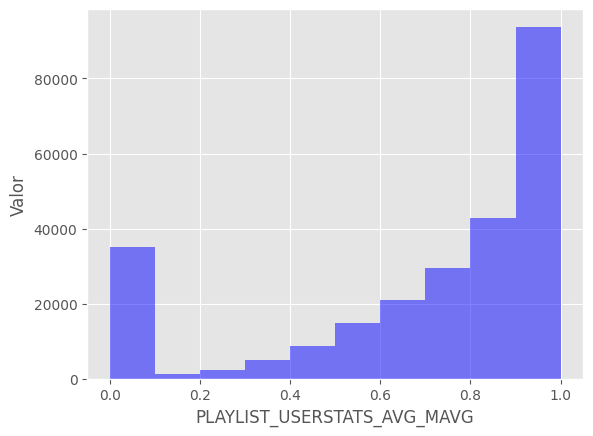

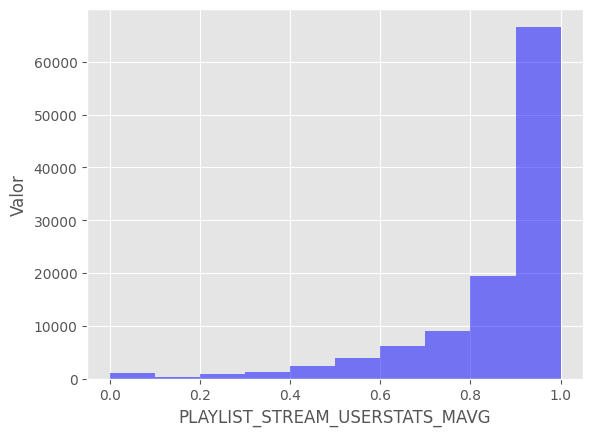

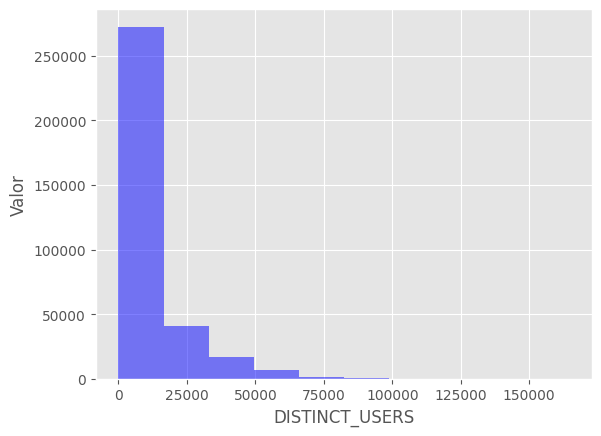

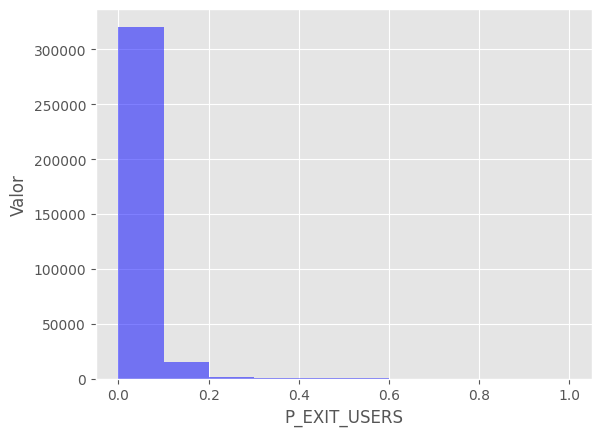

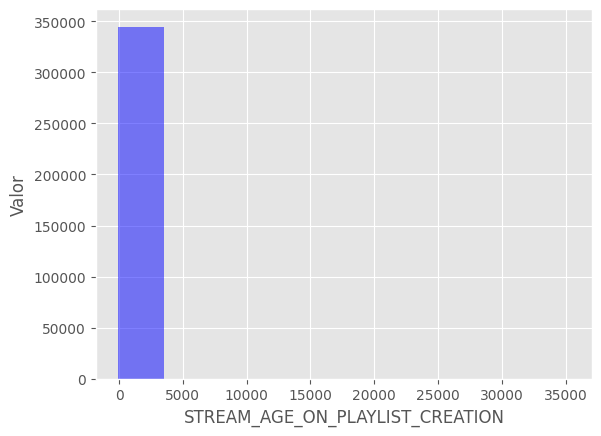

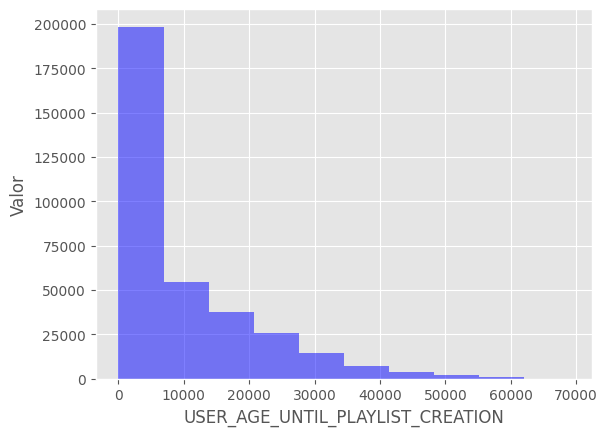

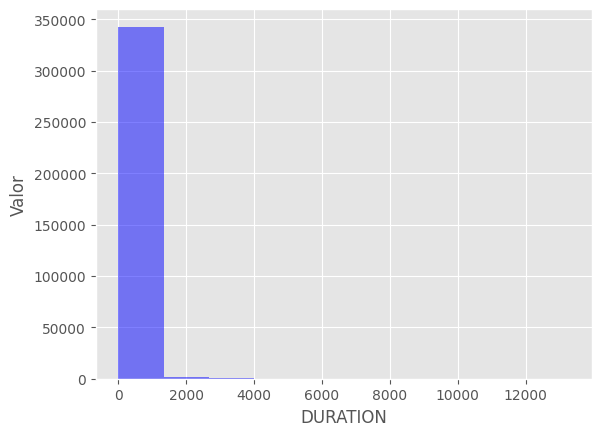

In [14]:
#Histograms
import matplotlib.mlab as mlab
plt.style.use('ggplot')
num_bins = 10
data_0 = df

for i in inputs_num:
    n, bins, patches = plt.hist(data_0[i], num_bins, facecolor='blue', alpha=0.5)
    plt.xlabel(i)
    plt.ylabel('Valor')
    plt.show()

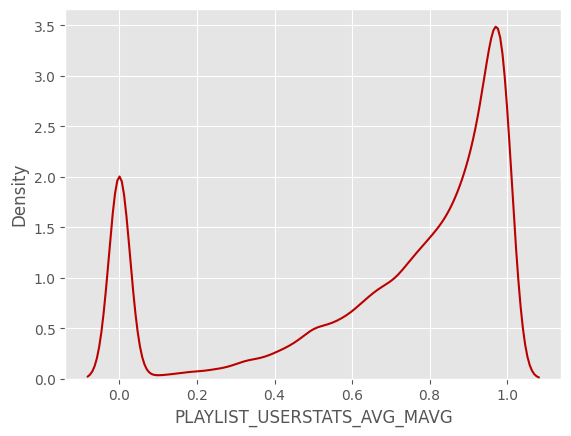

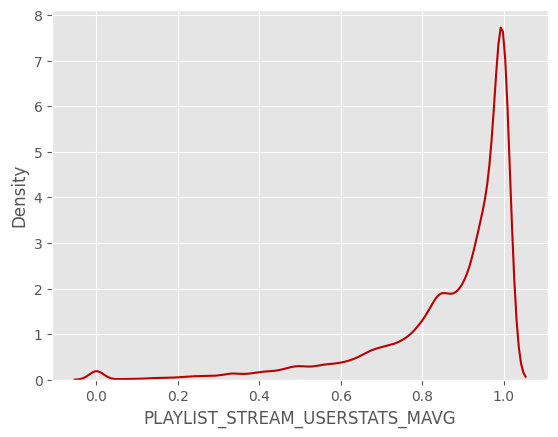

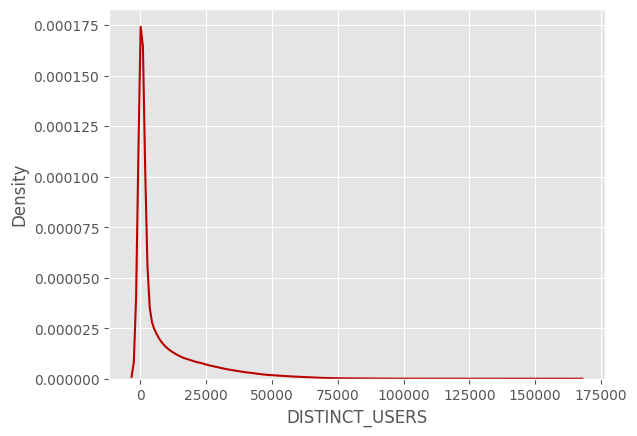

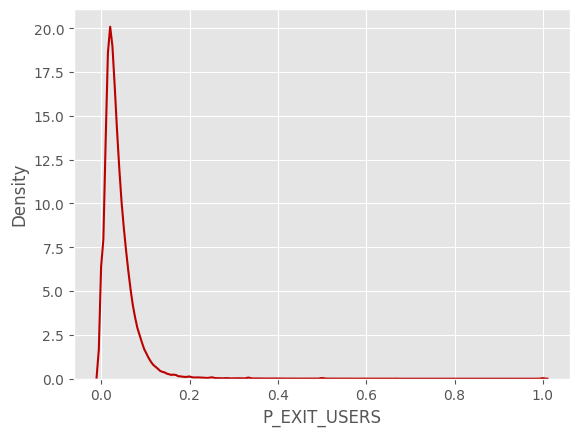

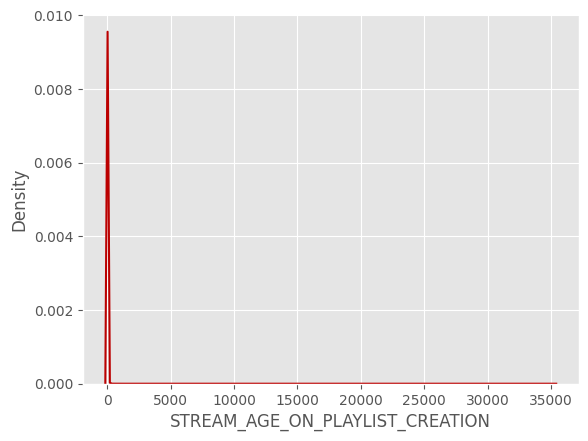

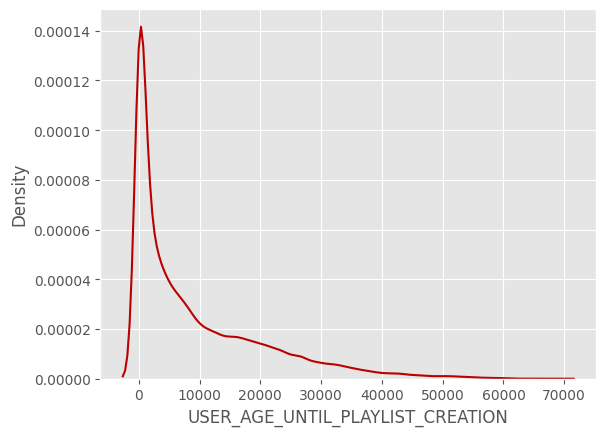

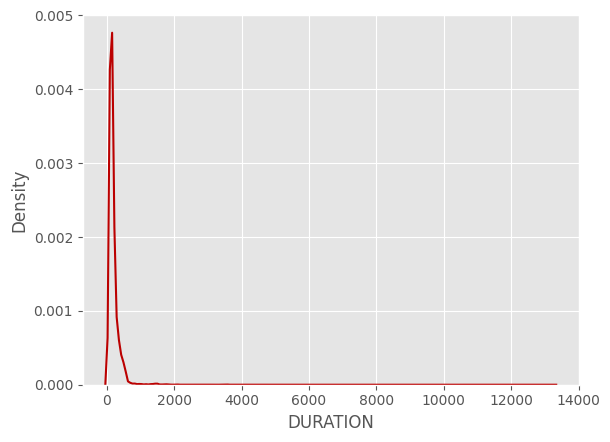

In [15]:
plt.style.use('ggplot')
num_bins = 10
data_0 = df

for i in inputs_num:
    sns.kdeplot(data_0[i],cumulative = False,color = "#BB0000")
    plt.show()

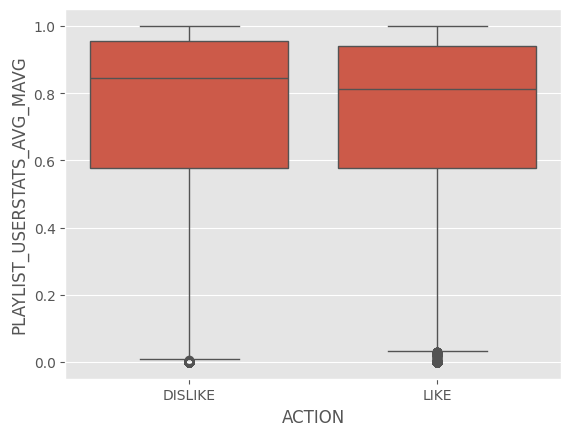

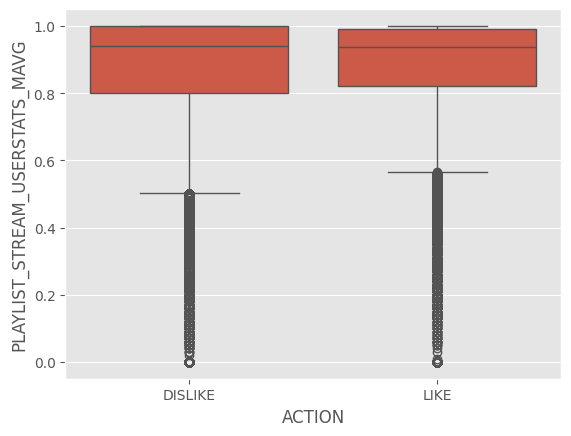

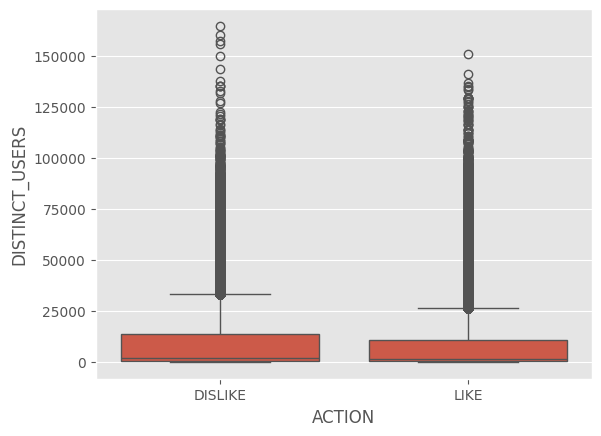

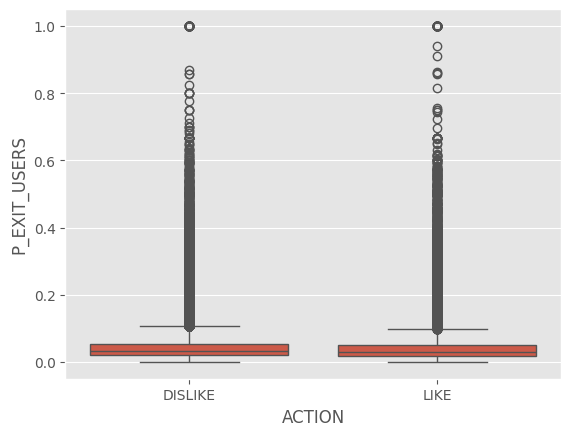

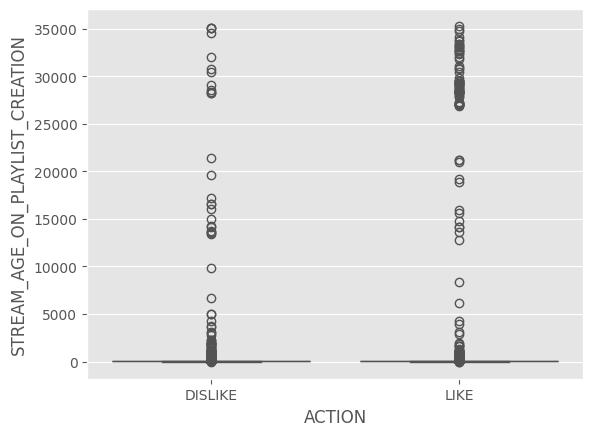

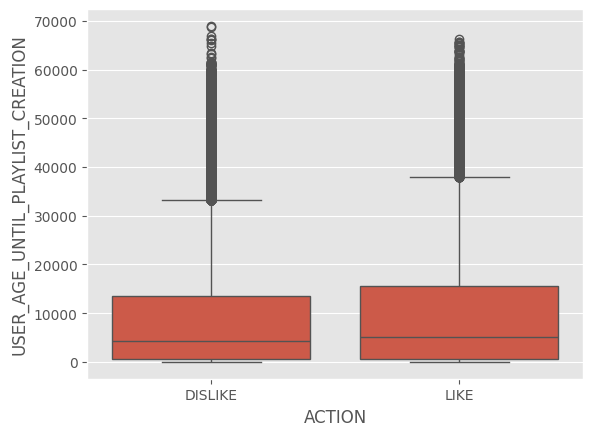

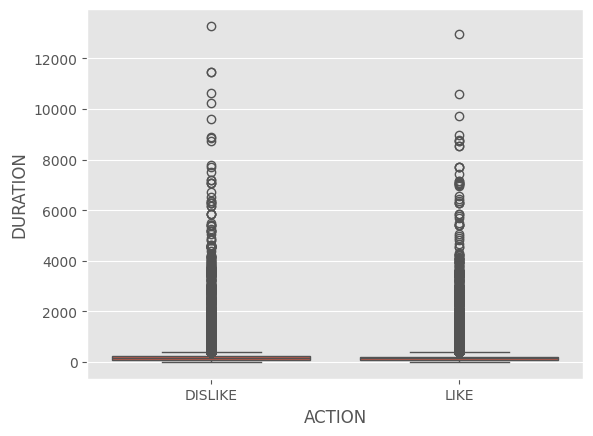

In [16]:
#Boxplot: cannot observe a notorious effect from any numeric feature at first sight
plt.style.use('ggplot')

for i in inputs_num:
    sns.boxplot(x=df['ACTION'],y=df[i])
    plt.show()

In [17]:
resumen_cat = df[inputs_cat].describe(include='all').T
resumen_cat

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CLIENT_OS,344800,12,roku,229060,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHANNEL_TYPE,344800,2,local,178764,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STREAM_AUTHOR,344800,286,abcnews,44145,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACTION,344800,2,LIKE,203605,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IS_FAVORITE_CHANNEL,344800.0,NaN,NaN,NaN,0.451876,0.497679,0.0,0.0,0.0,1.0,1.0
IS_FAVORITE_TAG,344800.0,NaN,NaN,NaN,0.175061,0.38002,0.0,0.0,0.0,0.0,1.0


In [18]:
#Encoding action
action_code = pd.get_dummies(df['ACTION']).astype(int)
action_code.head()

,DISLIKE,LIKE
0,1,0
1,1,0
2,0,1
3,0,1
4,1,0


In [19]:
df_fixed = pd.concat([df, action_code['LIKE']], axis=1)
df_fixed.head()

,ACTION,TITLE,DESCRIPTION,CLIENT_OS,CHANNEL_TYPE,CREATED_AT,STREAM_URL,STREAM_AUTHOR,PLAYLIST_STREAM_PW,PLAYLIST_USERSTATS_AVG_MAVG,PLAYLIST_STREAM_USERSTATS_MAVG,DISTINCT_USERS,P_EXIT_USERS,STREAM_AGE_ON_PLAYLIST_CREATION,USER_AGE_UNTIL_PLAYLIST_CREATION,DURATION,IS_FAVORITE_CHANNEL,IS_FAVORITE_TAG,LIKE
0,DISLIKE,This Car-Bike Hybrid Could Be the Future of Ci...,"It&rsquo;s safer than an e-bike, but even more...",roku,national,2022-07-01 22:52:44.320000-05:00,http://haystack.tv/id/eAkzbFgmc,amazelab,NaN,1.000000,NaN,12324.0,0.016310,15.0,744.0,76.567,0,0,0
1,DISLIKE,This Car-Bike Hybrid Could Be the Future of Ci...,"It&rsquo;s safer than an e-bike, but even more...",firetv,national,2022-07-01 23:39:46.149000-05:00,http://haystack.tv/id/eAkzbFgmc,amazelab,0.60,0.877527,0.96,12783.0,0.016897,16.0,38542.0,76.567,1,0,0
2,LIKE,This Car-Bike Hybrid Could Be the Future of Ci...,"It&rsquo;s safer than an e-bike, but even more...",android,national,2022-07-02 02:16:46.420000-05:00,http://haystack.tv/id/eAkzbFgmc,amazelab,0.60,0.357807,NaN,13947.0,0.017567,19.0,624.0,76.567,1,0,1
3,LIKE,This Car-Bike Hybrid Could Be the Future of Ci...,"It&rsquo;s safer than an e-bike, but even more...",roku,national,2022-07-02 03:03:13.056000-05:00,http://haystack.tv/id/eAkzbFgmc,amazelab,0.59,1.000000,NaN,15678.0,0.018051,20.0,976.0,76.567,0,0,1
4,DISLIKE,This Car-Bike Hybrid Could Be the Future of Ci...,"It&rsquo;s safer than an e-bike, but even more...",vizio,national,2022-07-02 03:38:23.181000-05:00,http://haystack.tv/id/eAkzbFgmc,amazelab,0.57,0.000000,NaN,16466.0,0.019070,20.0,14512.0,76.567,0,0,0


In [20]:
inputs_cat=['CLIENT_OS', 'CHANNEL_TYPE','LIKE','STREAM_AUTHOR','IS_FAVORITE_CHANNEL',
       'IS_FAVORITE_TAG']

In [21]:
resumen_cat = df_fixed[inputs_cat].describe(include='all').T
resumen_cat

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CLIENT_OS,344800,12,roku,229060,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHANNEL_TYPE,344800,2,local,178764,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LIKE,344800.0,NaN,NaN,NaN,0.590502,0.491742,0.0,0.0,1.0,1.0,1.0
STREAM_AUTHOR,344800,286,abcnews,44145,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IS_FAVORITE_CHANNEL,344800.0,NaN,NaN,NaN,0.451876,0.497679,0.0,0.0,0.0,1.0,1.0
IS_FAVORITE_TAG,344800.0,NaN,NaN,NaN,0.175061,0.38002,0.0,0.0,0.0,0.0,1.0


In [22]:
#Share of total events by operative system
(df_fixed.groupby('CLIENT_OS')['CLIENT_OS'].count()/df_fixed.shape[0]).sort_values(ascending=False)

CLIENT_OS
roku         0.664327
firetv       0.103445
android      0.066630
androidtv    0.038982
vizio        0.032880
samsung      0.028382
lg           0.026114
appletv      0.025876
iphone       0.010510
viziovia     0.001891
hisense      0.000597
opera        0.000365
Name: CLIENT_OS, dtype: float64

In [23]:
df_fixed['MONTH'] = df_fixed['CREATED_AT'].dt.strftime('%m-%Y')

In [24]:
df_fixed.head()

,ACTION,TITLE,DESCRIPTION,CLIENT_OS,CHANNEL_TYPE,CREATED_AT,STREAM_URL,STREAM_AUTHOR,PLAYLIST_STREAM_PW,PLAYLIST_USERSTATS_AVG_MAVG,PLAYLIST_STREAM_USERSTATS_MAVG,DISTINCT_USERS,P_EXIT_USERS,STREAM_AGE_ON_PLAYLIST_CREATION,USER_AGE_UNTIL_PLAYLIST_CREATION,DURATION,IS_FAVORITE_CHANNEL,IS_FAVORITE_TAG,LIKE,MONTH
0,DISLIKE,This Car-Bike Hybrid Could Be the Future of Ci...,"It&rsquo;s safer than an e-bike, but even more...",roku,national,2022-07-01 22:52:44.320000-05:00,http://haystack.tv/id/eAkzbFgmc,amazelab,NaN,1.000000,NaN,12324.0,0.016310,15.0,744.0,76.567,0,0,0,07-2022
1,DISLIKE,This Car-Bike Hybrid Could Be the Future of Ci...,"It&rsquo;s safer than an e-bike, but even more...",firetv,national,2022-07-01 23:39:46.149000-05:00,http://haystack.tv/id/eAkzbFgmc,amazelab,0.60,0.877527,0.96,12783.0,0.016897,16.0,38542.0,76.567,1,0,0,07-2022
2,LIKE,This Car-Bike Hybrid Could Be the Future of Ci...,"It&rsquo;s safer than an e-bike, but even more...",android,national,2022-07-02 02:16:46.420000-05:00,http://haystack.tv/id/eAkzbFgmc,amazelab,0.60,0.357807,NaN,13947.0,0.017567,19.0,624.0,76.567,1,0,1,07-2022
3,LIKE,This Car-Bike Hybrid Could Be the Future of Ci...,"It&rsquo;s safer than an e-bike, but even more...",roku,national,2022-07-02 03:03:13.056000-05:00,http://haystack.tv/id/eAkzbFgmc,amazelab,0.59,1.000000,NaN,15678.0,0.018051,20.0,976.0,76.567,0,0,1,07-2022
4,DISLIKE,This Car-Bike Hybrid Could Be the Future of Ci...,"It&rsquo;s safer than an e-bike, but even more...",vizio,national,2022-07-02 03:38:23.181000-05:00,http://haystack.tv/id/eAkzbFgmc,amazelab,0.57,0.000000,NaN,16466.0,0.019070,20.0,14512.0,76.567,0,0,0,07-2022


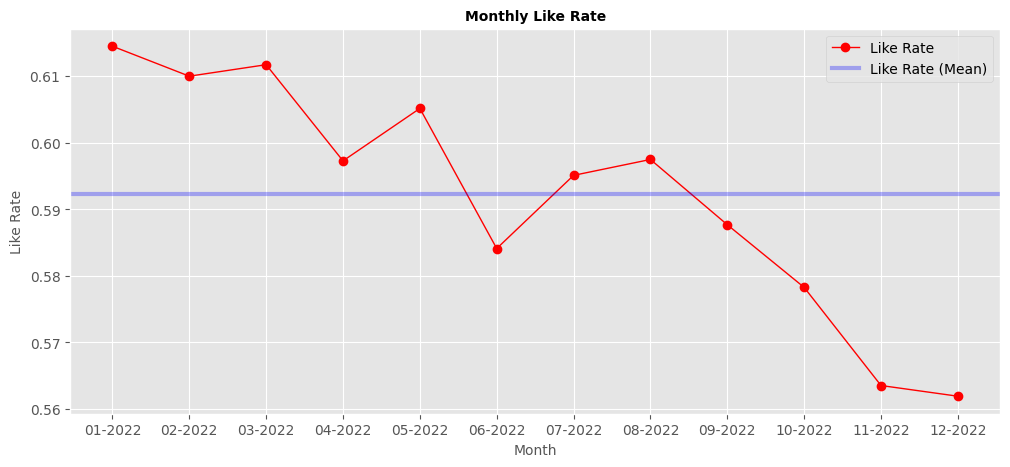

In [25]:
#Plotting monthly evolution of Like Rate %, Videos, Active Channels &  Videos-per-Channel Ratio
like_rate_per_month = df_fixed.groupby('MONTH')['LIKE'].mean()
like_rate_mean = like_rate_per_month.mean()

# Plot data
f, ax = plt.subplots(figsize=(12, 5))
plt.plot(like_rate_per_month.index, like_rate_per_month, '-o', color='red', linewidth=1, label='Like Rate')
plt.axhline(like_rate_mean, color='blue', linestyle='-', linewidth=3, alpha=0.3, label='Like Rate (Mean)')

# Format plot
plt.title('Monthly Like Rate', fontsize=10, weight='bold')
plt.ylabel('Like Rate', fontsize=10)
plt.xlabel('Month', fontsize=10)
plt.legend()
plt.show()

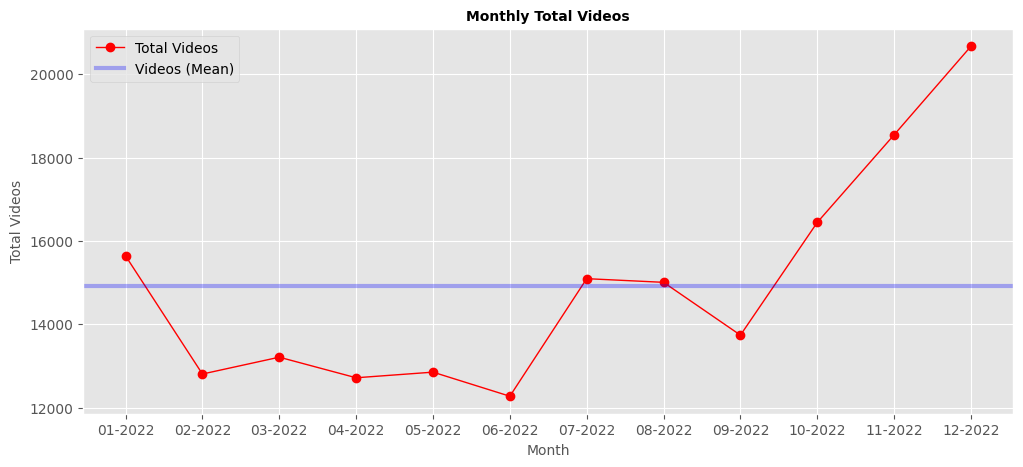

In [26]:
videos_per_month = df_fixed.groupby('MONTH')['STREAM_URL'].nunique()
videos_mean = videos_per_month.mean()

# Plot data
f, ax = plt.subplots(figsize=(12, 5))
plt.plot(videos_per_month.index, videos_per_month, '-o', color='red', linewidth=1, label='Total Videos')
plt.axhline(videos_mean, color='blue', linestyle='-', linewidth=3, alpha=0.3, label='Videos (Mean)')

# Format plot
plt.title('Monthly Total Videos', fontsize=10, weight='bold')
plt.ylabel('Total Videos', fontsize=10)
plt.xlabel('Month', fontsize=10)
plt.legend()
plt.show()

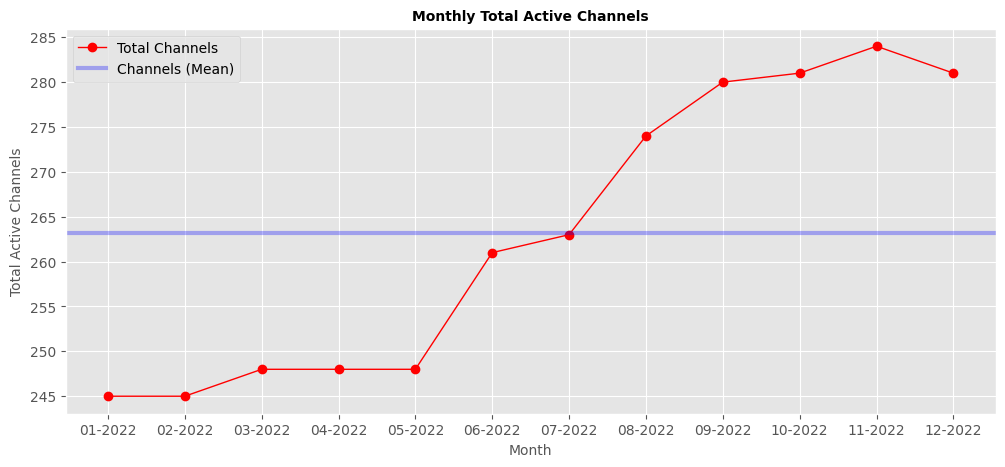

In [27]:
authors_per_month = df_fixed.groupby('MONTH')['STREAM_AUTHOR'].nunique()
authors_mean = authors_per_month.mean()

# Plot data
f, ax = plt.subplots(figsize=(12, 5))
plt.plot(authors_per_month.index, authors_per_month, '-o', color='red', linewidth=1, label='Total Channels')
plt.axhline(authors_mean, color='blue', linestyle='-', linewidth=3, alpha=0.3, label='Channels (Mean)')

# Format plot
plt.title('Monthly Total Active Channels', fontsize=10, weight='bold')
plt.ylabel('Total Active Channels', fontsize=10)
plt.xlabel('Month', fontsize=10)
plt.legend()
plt.show()

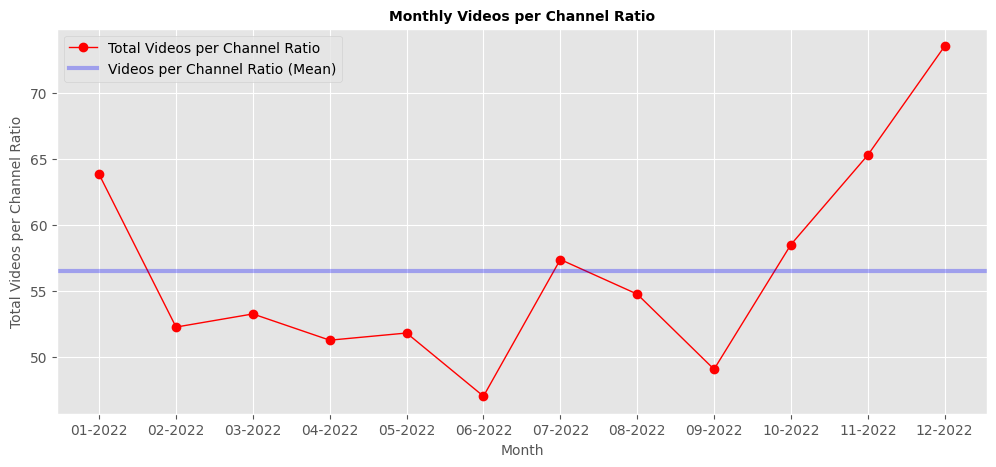

In [28]:
videos_by_author=df_fixed.groupby('MONTH')['STREAM_URL'].nunique()/df_fixed.groupby('MONTH')['STREAM_AUTHOR'].nunique()
videos_by_author_mean = videos_by_author.mean()

# Plot data
f, ax = plt.subplots(figsize=(12, 5))
plt.plot(videos_by_author.index, videos_by_author, '-o', color='red', linewidth=1, label='Total Videos per Channel Ratio')
plt.axhline(videos_by_author_mean, color='blue', linestyle='-', linewidth=3, alpha=0.3, label='Videos per Channel Ratio (Mean)')

# Format plot
plt.title('Monthly Videos per Channel Ratio', fontsize=10, weight='bold')
plt.ylabel('Total Videos per Channel Ratio', fontsize=10)
plt.xlabel('Month', fontsize=10)
plt.legend()
plt.show()

In [29]:
#Categorizing numerical features, based on percentiles
for i in inputs_num:
 
    q1 = np.nanpercentile(df_fixed[i], 25)
    q2 = np.nanpercentile(df_fixed[i], 50)
    q3 = np.nanpercentile(df_fixed[i], 75)
    

    def categorize_value(x):
        if pd.isnull(x):
            return 'NULL_VALUE'
        elif x <= q1:
            return '<= 1st Quartile'
        elif q1 < x <= q2:
            return '1st-2nd Quartile'
        elif q2 < x <= q3:
            return '2nd-3rd Quartile'
        else:
            return '> 3rd Quartile'
    
 
    df_fixed[i + '_CATEGORY'] = df_fixed[i].apply(categorize_value)

In [30]:
inputs_cat_no_target=['CLIENT_OS', 'CHANNEL_TYPE','IS_FAVORITE_CHANNEL',
       'IS_FAVORITE_TAG','PLAYLIST_USERSTATS_AVG_MAVG_CATEGORY', 'PLAYLIST_STREAM_USERSTATS_MAVG_CATEGORY',
       'DISTINCT_USERS_CATEGORY', 'P_EXIT_USERS_CATEGORY', 'STREAM_AGE_ON_PLAYLIST_CREATION_CATEGORY',
       'USER_AGE_UNTIL_PLAYLIST_CREATION_CATEGORY', 'DURATION_CATEGORY']

In [31]:
df_fixed.head()

,ACTION,TITLE,DESCRIPTION,CLIENT_OS,CHANNEL_TYPE,CREATED_AT,STREAM_URL,STREAM_AUTHOR,PLAYLIST_STREAM_PW,PLAYLIST_USERSTATS_AVG_MAVG,...,IS_FAVORITE_TAG,LIKE,MONTH,PLAYLIST_USERSTATS_AVG_MAVG_CATEGORY,PLAYLIST_STREAM_USERSTATS_MAVG_CATEGORY,DISTINCT_USERS_CATEGORY,P_EXIT_USERS_CATEGORY,STREAM_AGE_ON_PLAYLIST_CREATION_CATEGORY,USER_AGE_UNTIL_PLAYLIST_CREATION_CATEGORY,DURATION_CATEGORY
0,DISLIKE,This Car-Bike Hybrid Could Be the Future of Ci...,"It&rsquo;s safer than an e-bike, but even more...",roku,national,2022-07-01 22:52:44.320000-05:00,http://haystack.tv/id/eAkzbFgmc,amazelab,NaN,1.000000,...,0,0,07-2022,> 3rd Quartile,NULL_VALUE,> 3rd Quartile,<= 1st Quartile,2nd-3rd Quartile,1st-2nd Quartile,<= 1st Quartile
1,DISLIKE,This Car-Bike Hybrid Could Be the Future of Ci...,"It&rsquo;s safer than an e-bike, but even more...",firetv,national,2022-07-01 23:39:46.149000-05:00,http://haystack.tv/id/eAkzbFgmc,amazelab,0.60,0.877527,...,0,0,07-2022,2nd-3rd Quartile,2nd-3rd Quartile,> 3rd Quartile,<= 1st Quartile,> 3rd Quartile,> 3rd Quartile,<= 1st Quartile
2,LIKE,This Car-Bike Hybrid Could Be the Future of Ci...,"It&rsquo;s safer than an e-bike, but even more...",android,national,2022-07-02 02:16:46.420000-05:00,http://haystack.tv/id/eAkzbFgmc,amazelab,0.60,0.357807,...,0,1,07-2022,<= 1st Quartile,NULL_VALUE,> 3rd Quartile,<= 1st Quartile,> 3rd Quartile,1st-2nd Quartile,<= 1st Quartile
3,LIKE,This Car-Bike Hybrid Could Be the Future of Ci...,"It&rsquo;s safer than an e-bike, but even more...",roku,national,2022-07-02 03:03:13.056000-05:00,http://haystack.tv/id/eAkzbFgmc,amazelab,0.59,1.000000,...,0,1,07-2022,> 3rd Quartile,NULL_VALUE,> 3rd Quartile,1st-2nd Quartile,> 3rd Quartile,1st-2nd Quartile,<= 1st Quartile
4,DISLIKE,This Car-Bike Hybrid Could Be the Future of Ci...,"It&rsquo;s safer than an e-bike, but even more...",vizio,national,2022-07-02 03:38:23.181000-05:00,http://haystack.tv/id/eAkzbFgmc,amazelab,0.57,0.000000,...,0,0,07-2022,<= 1st Quartile,NULL_VALUE,> 3rd Quartile,1st-2nd Quartile,> 3rd Quartile,2nd-3rd Quartile,<= 1st Quartile


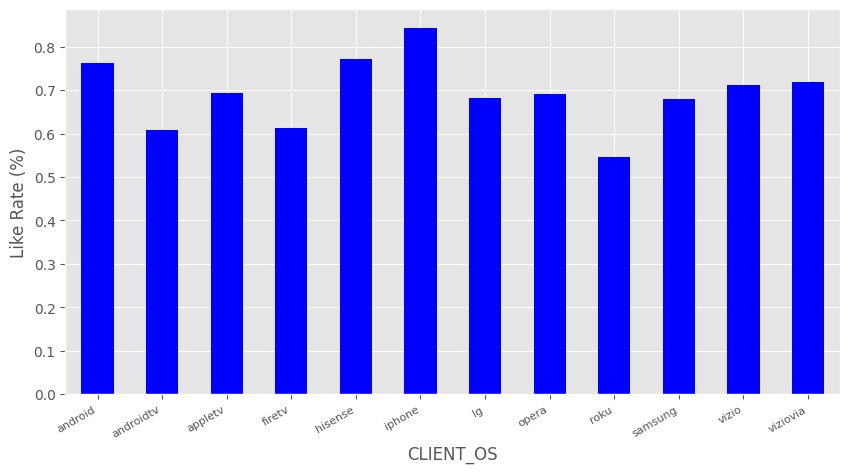

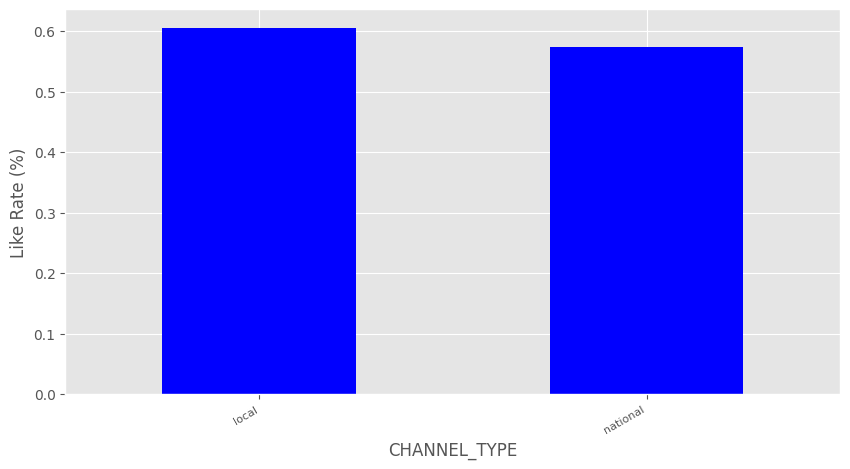

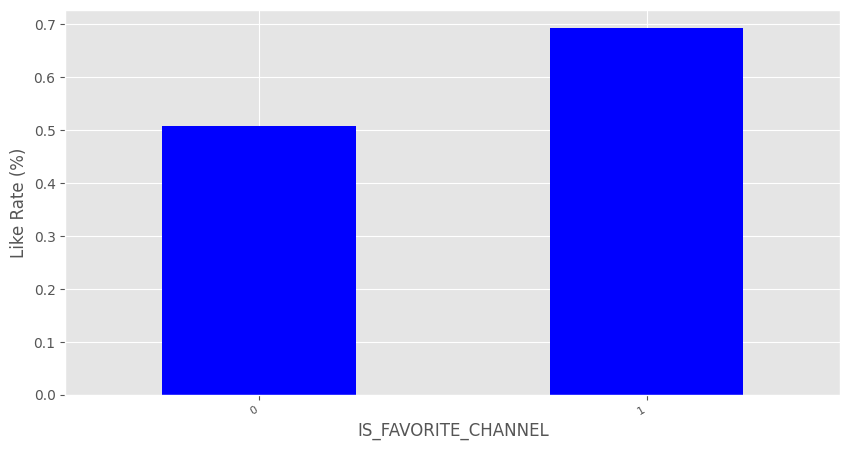

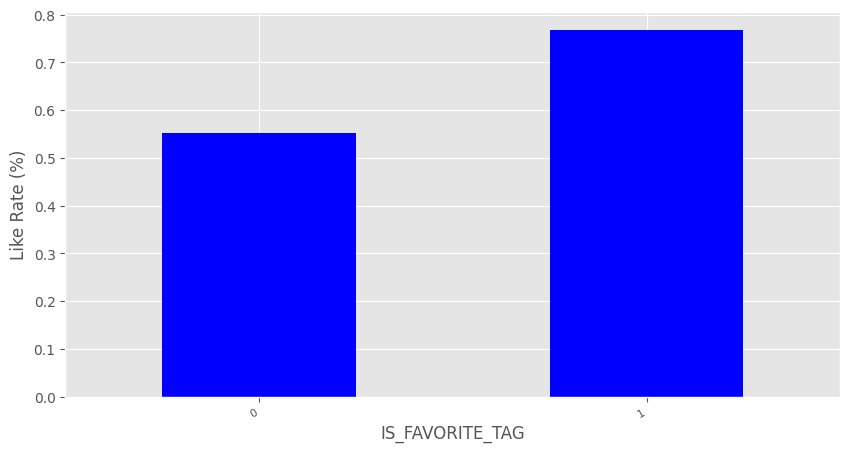

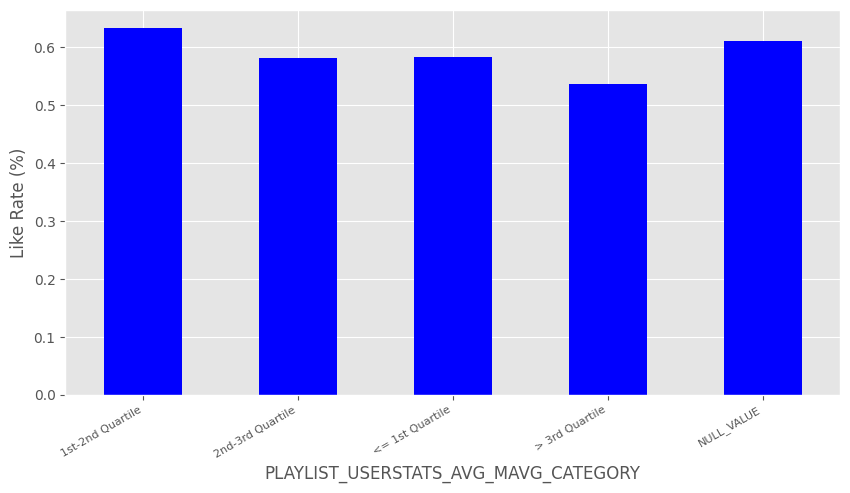

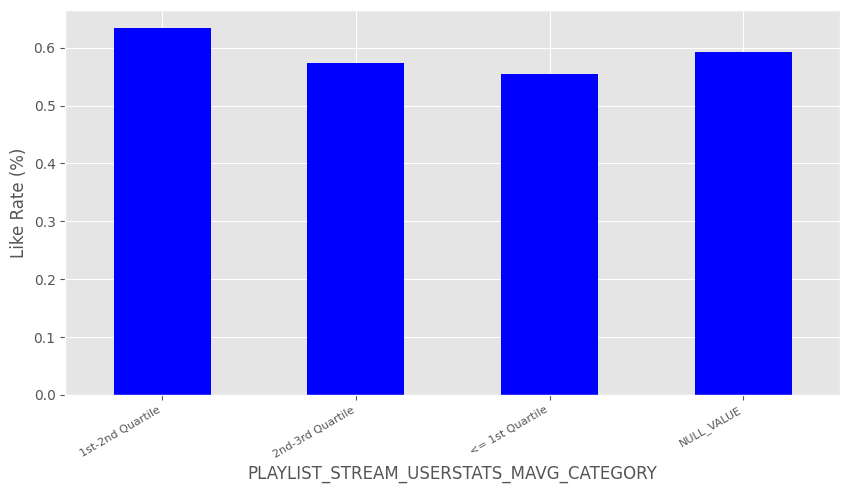

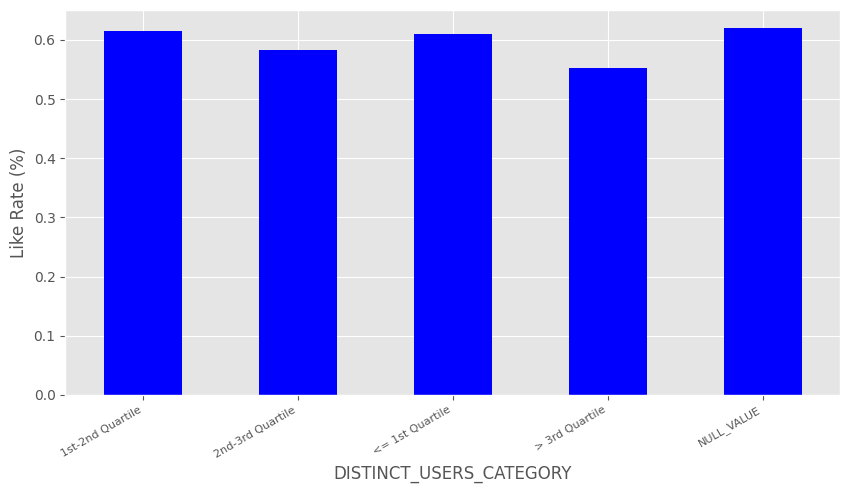

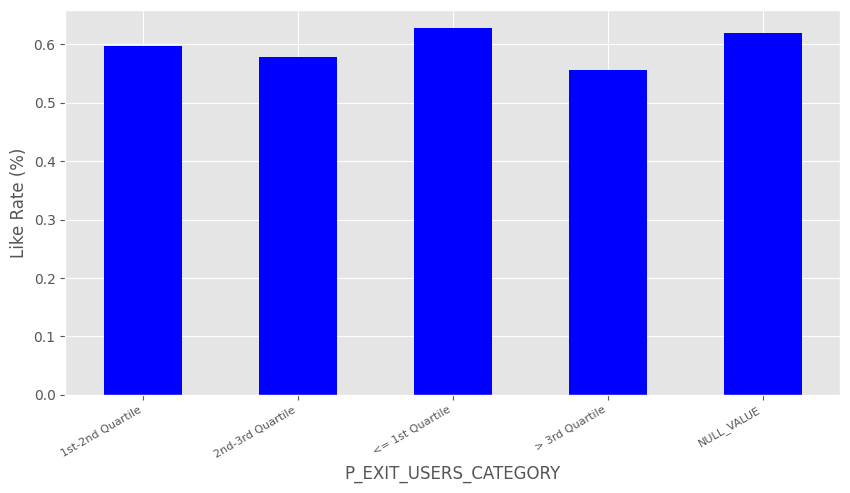

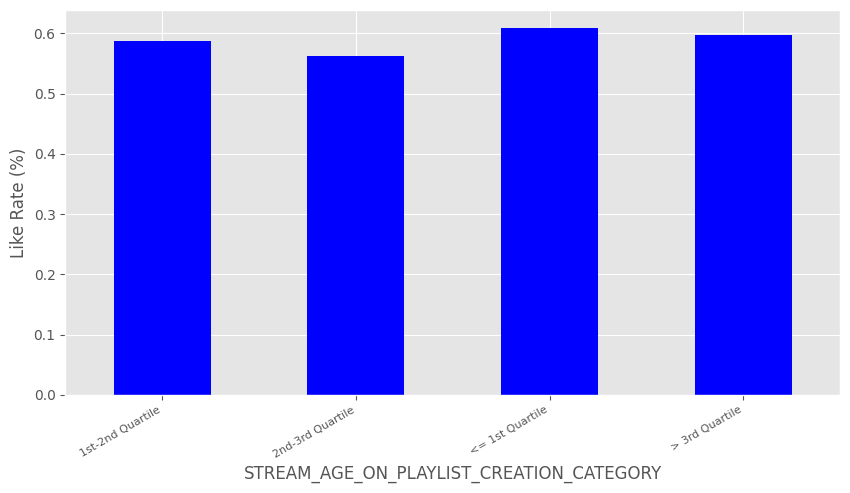

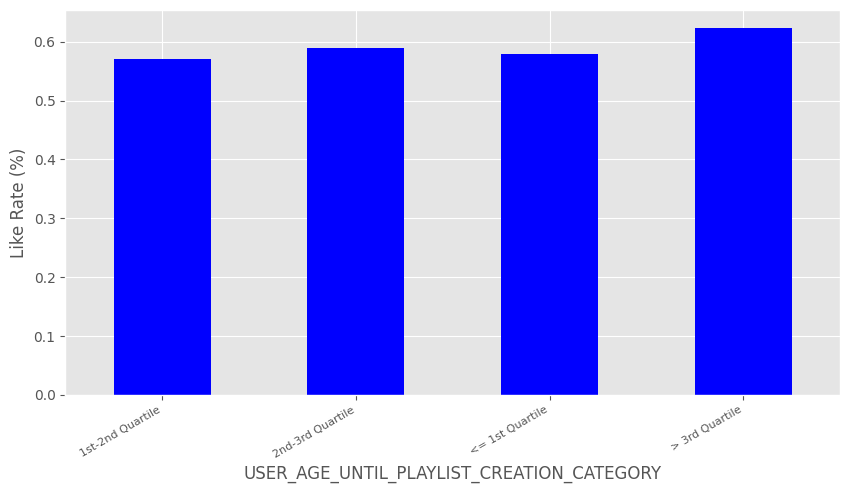

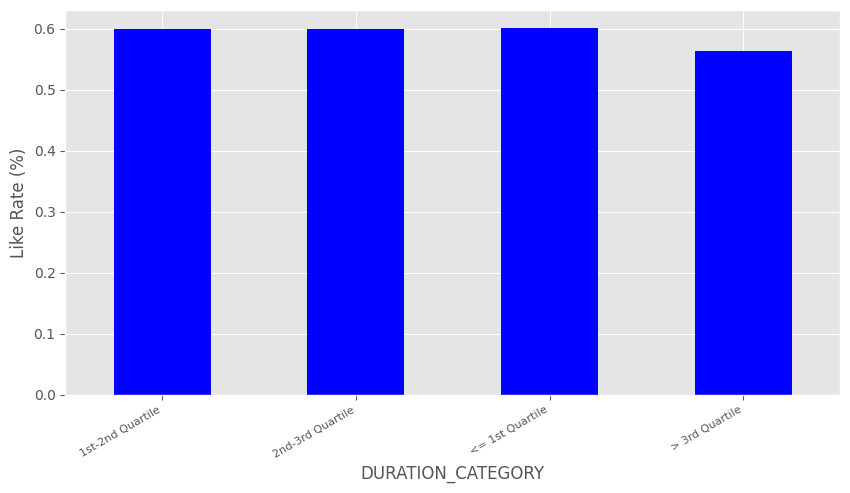

In [32]:
#Comparing the Like Rate% by each value of categorical features: effects of OS, Channel & Video marked as favorites are very likely
for i in inputs_cat_no_target:
    resumen = pd.concat([df_fixed[df_fixed.LIKE == 0].groupby(i).LIKE.count()
                          , df_fixed[df_fixed.LIKE == 1].groupby(i).LIKE.count()], axis=1)
    resumen.columns = ['Dislike','Like']
    resumen_f = resumen.Like / (resumen.Like + resumen.Dislike)
    plt.figure(figsize=(10,5))
    ax = resumen_f.plot(kind = 'bar', color = 'b')
    ax.set_xticklabels(resumen_f.index, rotation=30, fontsize=8, ha='right')
    ax.set_xlabel(i)
    ax.set_ylabel('Like Rate (%)')

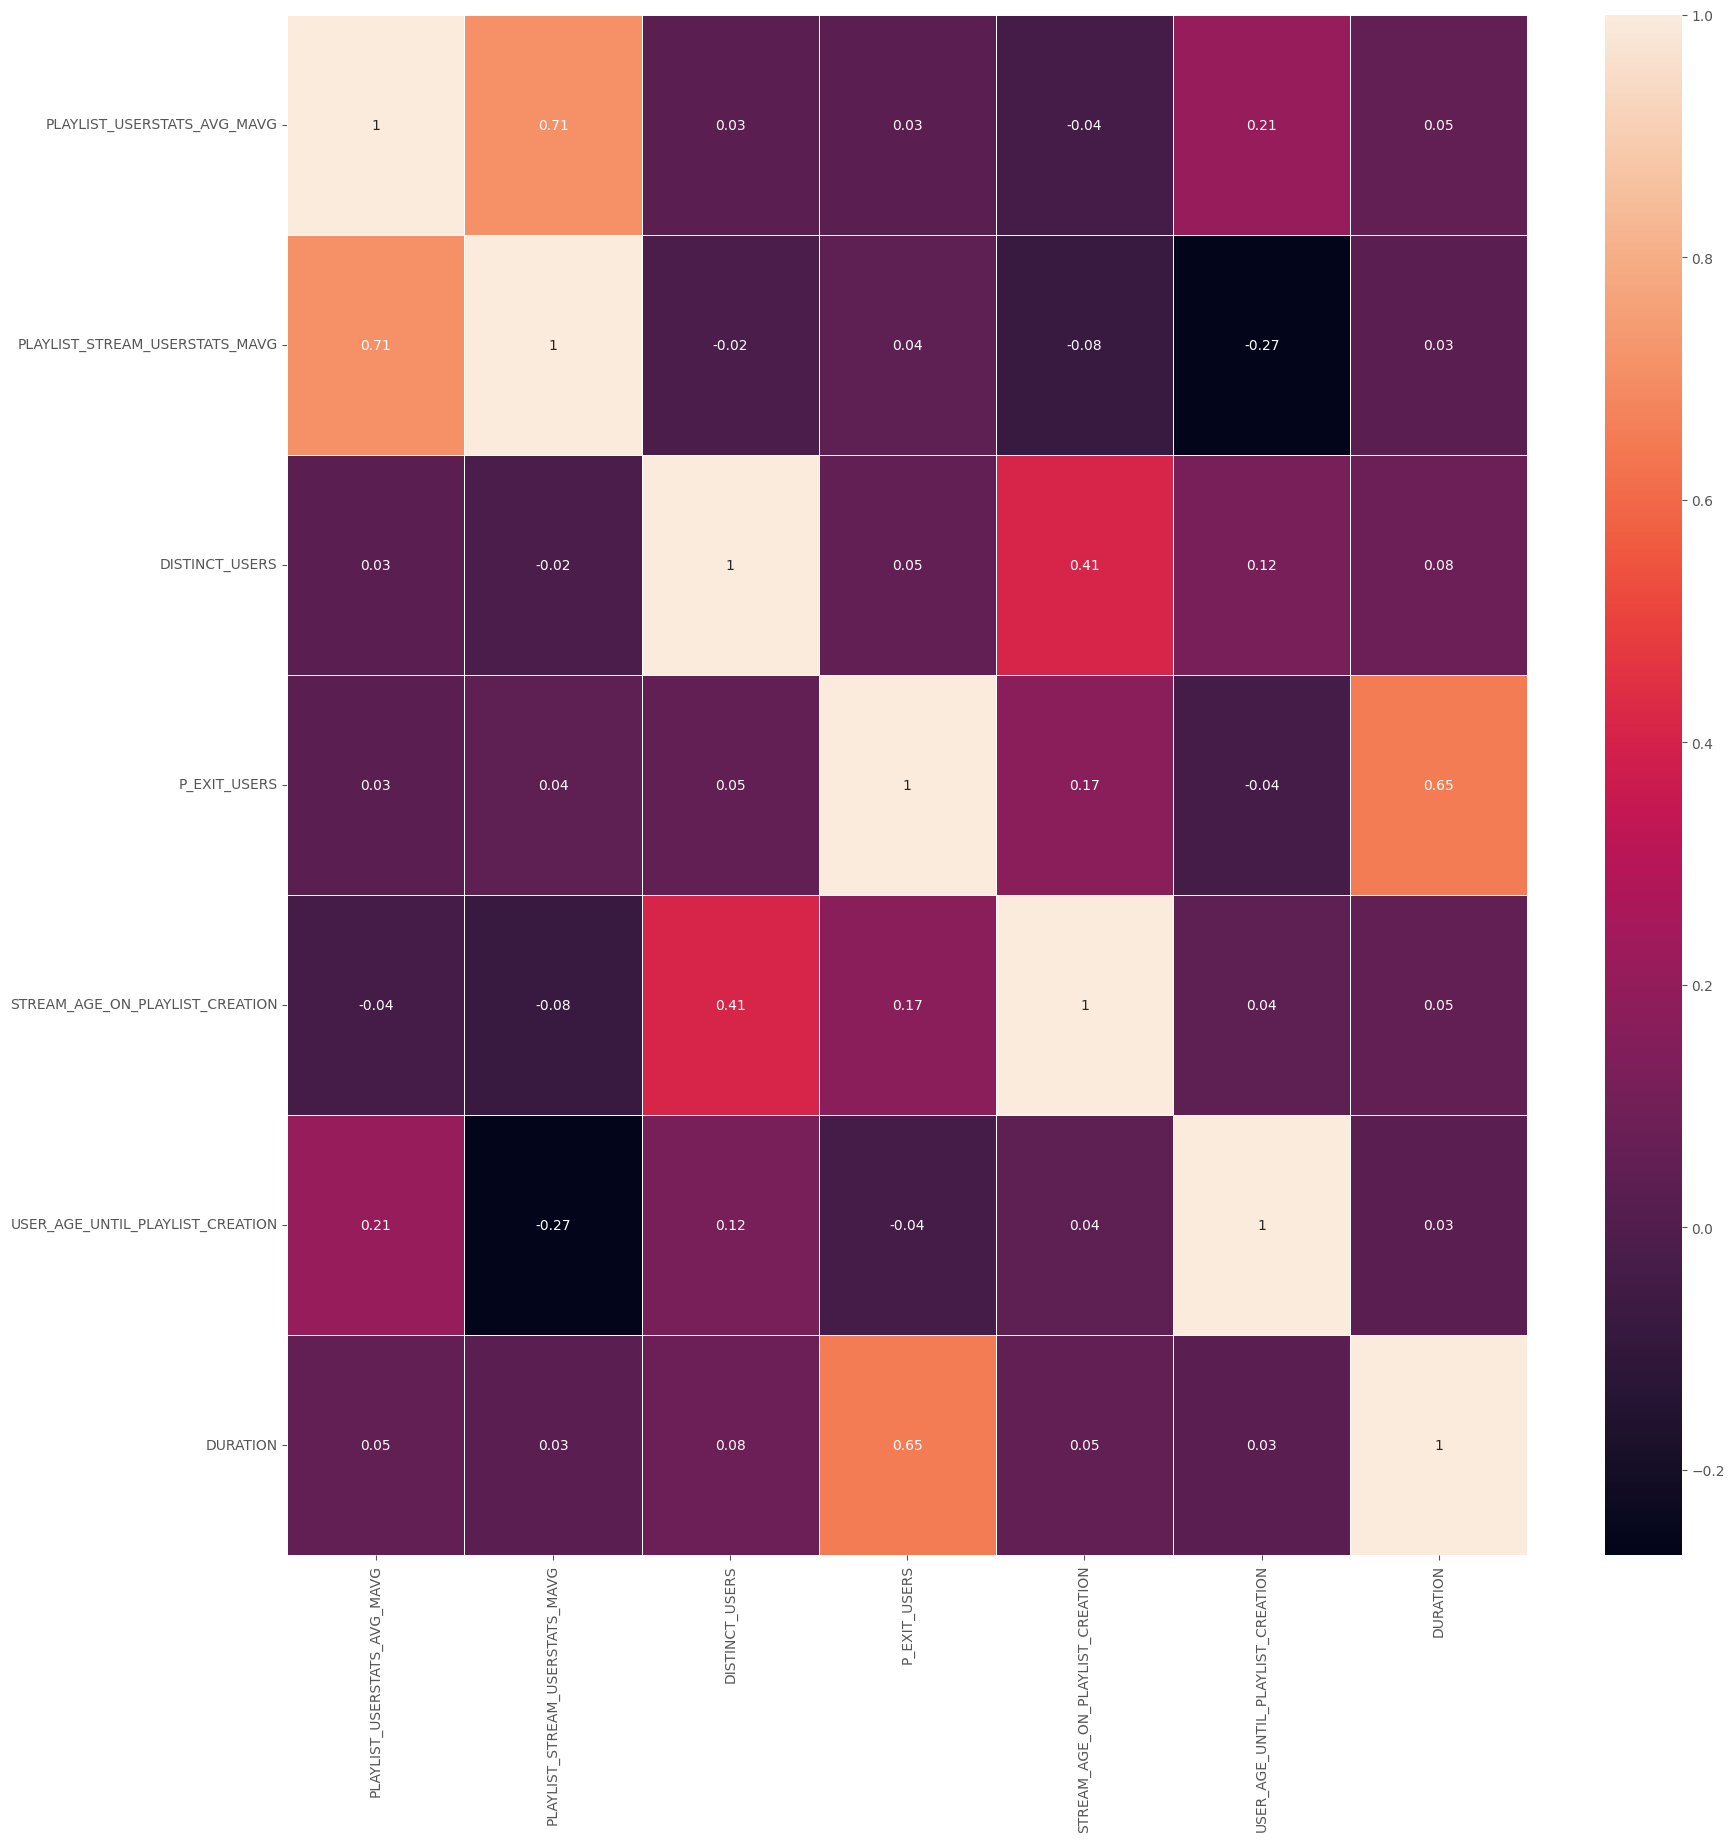

In [33]:
#Correlation matrix will be useful to avoid multi-collinearity, we will dive deep into it on the following steps
matrix=df_fixed[inputs_num].corr(method='spearman').round(2)
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(matrix,annot=True,linewidths=.5, ax=ax)
plt.show()

In [34]:
#PLAYLIST_STREAM_USERSTATS_MAVG has the highest missing data rate, but all channels have at least one non-null value and that will be useful for the imputation procedure
(df_fixed.groupby('STREAM_AUTHOR')['PLAYLIST_STREAM_USERSTATS_MAVG'].count()/df_fixed.groupby('STREAM_AUTHOR')['STREAM_AUTHOR'].count()).sort_values(ascending=False)

STREAM_AUTHOR
newsyhub                  0.721697
clevvernews               0.711864
euronews                  0.703059
thrnetwork                0.692562
amazelab                  0.692283
                            ...   
praedictix_national       0.000000
praedictix_minneapolis    0.000000
praedictix_dc             0.000000
praedictix_dallas         0.000000
praedictix_losangeles     0.000000
Length: 286, dtype: float64

# Feature Engineering
## This step will focus on treating missing values, standardization & feature generation


## Treating Missing Values
### *Imputation on probability features (playlist-related) uses median values by Channel & Operative System (depends on the feature)
### *Imputation for distinct users is based on median users by OS, Channel & Video Release Date (new feature POSTED_AT, calculated as the date of the first interaction with each video) 

In [35]:
query="""
   WITH VIDEO_PW AS
   (SELECT STREAM_AUTHOR,
   MEDIAN(PLAYLIST_STREAM_PW) AS MEDIAN_STREAM_PW
   FROM df_fixed GROUP BY 1)
   ,
   USERSTAT_AVG AS
   (SELECT CLIENT_OS,
   MEDIAN(PLAYLIST_USERSTATS_AVG_MAVG) AS USERSTAT_MEDIAN
   FROM df_fixed GROUP BY 1
   )
   ,
   STREAM_USERSTATS_AVG AS
   (SELECT STREAM_AUTHOR,
   MEDIAN(PLAYLIST_STREAM_USERSTATS_MAVG/PLAYLIST_USERSTATS_AVG_MAVG) AS STREAM_RATIO_MEDIAN,
   MEDIAN(PLAYLIST_STREAM_USERSTATS_MAVG) AS STREAM_STAT_MEDIAN
   FROM df_fixed WHERE PLAYLIST_STREAM_USERSTATS_MAVG IS NOT NULL AND PLAYLIST_USERSTATS_AVG_MAVG IS NOT NULL
   GROUP BY 1)
   ,
    STREAM_USERSTATS_AVG_TOTAL AS
   (SELECT 
   MEDIAN(PLAYLIST_STREAM_USERSTATS_MAVG/PLAYLIST_USERSTATS_AVG_MAVG) AS STREAM_RATIO_MEDIAN_TOTAL,
   MEDIAN(PLAYLIST_STREAM_USERSTATS_MAVG) AS STREAM_STAT_MEDIAN_TOTAL
   FROM df_fixed WHERE PLAYLIST_STREAM_USERSTATS_MAVG IS NOT NULL AND PLAYLIST_USERSTATS_AVG_MAVG IS NOT NULL)
   ,
   TREATED AS
   (SELECT
   D.* EXCLUDE(PLAYLIST_STREAM_PW,PLAYLIST_USERSTATS_AVG_MAVG,PLAYLIST_STREAM_USERSTATS_MAVG),
   MIN(DATE_TRUNC('DAY',CREATED_AT)) OVER (PARTITION BY D.STREAM_URL) AS POSTED_AT,
   COALESCE(D.PLAYLIST_STREAM_PW,VP.MEDIAN_STREAM_PW) PLAYLIST_STREAM_PW,
   COALESCE(D.PLAYLIST_USERSTATS_AVG_MAVG,UA.USERSTAT_MEDIAN) AS PLAYLIST_USERSTATS_AVG_MAVG,
   COALESCE(D.PLAYLIST_STREAM_USERSTATS_MAVG,COALESCE(D.PLAYLIST_USERSTATS_AVG_MAVG,UA.USERSTAT_MEDIAN)*SU.STREAM_RATIO_MEDIAN,SU.STREAM_STAT_MEDIAN,COALESCE(D.PLAYLIST_USERSTATS_AVG_MAVG,UA.USERSTAT_MEDIAN)*SUT.STREAM_RATIO_MEDIAN_TOTAL,SUT.STREAM_STAT_MEDIAN_TOTAL) PLAYLIST_STREAM_USERSTATS_MAVG
   from df_fixed AS D
   LEFT JOIN VIDEO_PW VP ON VP.STREAM_AUTHOR=D.STREAM_AUTHOR
   LEFT JOIN USERSTAT_AVG UA ON UA.CLIENT_OS=D.CLIENT_OS
   LEFT JOIN STREAM_USERSTATS_AVG  SU ON SU.STREAM_AUTHOR=D.STREAM_AUTHOR
   LEFT JOIN STREAM_USERSTATS_AVG_TOTAL SUT ON TRUE)
   ,
   UNIQUE_USERS AS
   (SELECT
   CLIENT_OS,
   STREAM_AUTHOR,
   POSTED_AT,
   MEDIAN(DISTINCT_USERS) AS MEDIAN_USERS,
   MEDIAN(P_EXIT_USERS) AS MEDIAN_P_EXIT
   FROM TREATED
   GROUP BY ALL)
   ,
   TREATED_V2 AS
   (SELECT
   T.* EXCLUDE(DISTINCT_USERS,P_EXIT_USERS),
   COALESCE(T.DISTINCT_USERS,U.MEDIAN_USERS) AS DISTINCT_USERS,
   COALESCE(T.P_EXIT_USERS,U.MEDIAN_P_EXIT) AS P_EXIT_USERS,
   CASE WHEN PLAYLIST_USERSTATS_AVG_MAVG=0 THEN 0 ELSE (PLAYLIST_STREAM_USERSTATS_MAVG/PLAYLIST_USERSTATS_AVG_MAVG) END AS STREAM_LIFT_BY_USER,
   (USER_AGE_UNTIL_PLAYLIST_CREATION-STREAM_AGE_ON_PLAYLIST_CREATION) AS HOURS_BETWEEN_VIDEO_POST_AND_USER_CREATION
   FROM TREATED T
   LEFT JOIN UNIQUE_USERS U ON U.CLIENT_OS=T.CLIENT_OS AND U.STREAM_AUTHOR=T.STREAM_AUTHOR AND U.POSTED_AT=T.POSTED_AT)
   ,
   USERS_BY_VIDEO AS
   (SELECT
   STREAM_AUTHOR,
   POSTED_AT,
   SUM(VIDEO_USERS) AS AUTHOR_DAY_ACTIVITY,
   SUM(AUTHOR_DAY_ACTIVITY) OVER (PARTITION BY DATE_TRUNC('WEEK',POSTED_AT),STREAM_AUTHOR) AS AUTHOR_WEEK_ACTIVITY
   FROM (SELECT
   STREAM_URL,
   POSTED_AT,
   STREAM_AUTHOR,
   MAX(DISTINCT_USERS) AS VIDEO_USERS
   FROM TREATED_V2
   GROUP BY ALL)
   GROUP BY 1,2)
   SELECT
   T2.*,
   UV.AUTHOR_DAY_ACTIVITY,
   UV.AUTHOR_WEEK_ACTIVITY
   FROM TREATED_V2 T2
   LEFT JOIN USERS_BY_VIDEO UV ON UV.STREAM_AUTHOR=T2.STREAM_AUTHOR AND UV.POSTED_AT=T2.POSTED_AT

"""

In [36]:
df_post_fe=duckdb.query(query).to_df()
df_post_fe.head()

,ACTION,TITLE,DESCRIPTION,CLIENT_OS,CHANNEL_TYPE,CREATED_AT,STREAM_URL,STREAM_AUTHOR,STREAM_AGE_ON_PLAYLIST_CREATION,USER_AGE_UNTIL_PLAYLIST_CREATION,...,POSTED_AT,PLAYLIST_STREAM_PW,PLAYLIST_USERSTATS_AVG_MAVG,PLAYLIST_STREAM_USERSTATS_MAVG,DISTINCT_USERS,P_EXIT_USERS,STREAM_LIFT_BY_USER,HOURS_BETWEEN_VIDEO_POST_AND_USER_CREATION,AUTHOR_DAY_ACTIVITY,AUTHOR_WEEK_ACTIVITY
0,LIKE,Scattered to numerous thunderstorms in the aft...,Scattered to numerous thunderstorms in the aft...,roku,local,2022-08-03 06:47:13.503000-05:00,http://haystack.tv/id/00AQPOiee,wvtm,42.0,11852.0,...,2022-08-03 00:00:00-05:00,0.19,0.852222,0.890368,613.0,0.061990,1.044761,11810.0,2337.0,6215.0
1,DISLIKE,"Oath Keepers trial to start Tuesday, two Flori...",More than 20 months since a mob attacked and r...,roku,local,2022-09-27 04:49:16.595000-05:00,http://haystack.tv/id/01H6FT2Je,wftx,10.0,116.0,...,2022-09-27 00:00:00-05:00,0.28,0.852222,0.906370,232.0,0.068966,1.063537,106.0,4581.0,56161.0
2,LIKE,Little Bacon Bear co-hosts Good Day DC!,Entertainment personality Little Bacon Bear jo...,firetv,local,2022-08-11 14:12:27.303000-05:00,http://haystack.tv/id/01uA2i8Bs,fox5dc,1.0,6060.0,...,2022-08-11 00:00:00-05:00,0.24,0.979882,1.025679,73.0,0.027397,1.046738,6059.0,4066.0,20514.0
3,LIKE,"Oscar Rosales, shooter in Houston murder of Pc...","Oscar Rosales, the suspect facing a capital mu...",roku,local,2022-01-26 21:22:20.741000-05:00,http://haystack.tv/id/02Wv0Joku,fox26houston,3.0,94.0,...,2022-01-26 00:00:00-05:00,0.50,0.852222,0.886666,564.0,0.017730,1.040417,91.0,4185.0,17115.0
4,LIKE,RANDOLPH-HENRY VS. APPOMATTOX,RANDOLPH-HENRY VS. APPOMATTOX,roku,local,2022-06-12 18:39:40.244000-05:00,http://haystack.tv/id/02f2q5aX,wfxr,43.0,19020.0,...,2022-06-11 00:00:00-05:00,0.10,0.852222,0.902226,429.0,0.044289,1.058675,18977.0,704.0,1844.0


In [37]:
df_post_fe.isnull().mean()

ACTION                                        0.000000
TITLE                                         0.000000
DESCRIPTION                                   0.000000
CLIENT_OS                                     0.000000
CHANNEL_TYPE                                  0.000000
CREATED_AT                                    0.000000
STREAM_URL                                    0.000000
STREAM_AUTHOR                                 0.000000
STREAM_AGE_ON_PLAYLIST_CREATION               0.000000
USER_AGE_UNTIL_PLAYLIST_CREATION              0.000000
DURATION                                      0.000000
IS_FAVORITE_CHANNEL                           0.000000
IS_FAVORITE_TAG                               0.000000
LIKE                                          0.000000
MONTH                                         0.000000
PLAYLIST_USERSTATS_AVG_MAVG_CATEGORY          0.000000
PLAYLIST_STREAM_USERSTATS_MAVG_CATEGORY       0.000000
DISTINCT_USERS_CATEGORY                       0.000000
P_EXIT_USE

## Feature Generation
#### * Generated a USER_ID by concatenating the following fields: Operative System, User Age & User's Probability to Watch each Video (all of them at the user level). This may have some level of error but can be helpful.
### * Features added where: 
#### * Event Hour 
#### * Event Day of the Week
#### * Stream Lift by User: PLAYLIST_STREAM_USERSTATS_MAVG/PLAYLIST_USERSTATS_AVG_MAVG (This represents how much greater the probability of watching a video from each channel is compared to the probability of watching any video for each user)
#### * Hours Between Video Post and User Creation: USER_AGE_UNTIL_PLAYLIST_CREATION-STREAM_AGE_ON_PLAYLIST_CREATION (This represents the time between the video upload and the creation of each user account)
#### *Total Videos the User Interacted With during each day: Aggregated using the USER_ID field mentioned above.
#### *Total Videos the User Interacted With: Similar to the previous field, but considering the entire timeframe.
#### *Author Day Activity: Total Users that Interacted with any Video from each Channel during each day.
#### *Author Week Activity: Total Users that Interacted with any Video from each Channel during each week.

In [38]:
#Creating "USER_ID" field
df_post_fe['USER_ID']=df_post_fe['CLIENT_OS']+df_post_fe['USER_AGE_UNTIL_PLAYLIST_CREATION'].astype(str)+df_post_fe['PLAYLIST_USERSTATS_AVG_MAVG'].astype(str)
df_post_fe['HOUR']=df_post_fe['CREATED_AT'].dt.hour
df_post_fe['DAY_OF_WEEK']=df_post_fe['CREATED_AT'].dt.dayofweek
print(f"{df_post_fe['USER_ID'].nunique()} unique users")
print(f"{df_post_fe.shape[0]/df_post_fe['USER_ID'].nunique()} as activity ratio (interactions/unique users)")

208622 unique users
1.6527499496697375 as activity ratio (interactions/unique users)


In [39]:
#Only 0.5% of rows have missing values
df_post_fe.dropna().shape[0]/df_post_fe.shape[0]

0.9953045243619489

In [40]:
query_final="""
   SELECT
   *,
   COUNT(1) OVER (PARTITION BY USER_ID,DATE_TRUNC('DAY',CREATED_AT)) AS TOTAL_VIDEOS_USER_DAY,
   COUNT(1) OVER (PARTITION BY USER_ID) AS TOTAL_VIDEOS_USER,
   ROW_NUMBER() OVER (PARTITION BY USER_ID ORDER BY CREATED_AT) AS N_VIDEO_FOR_USER
   FROM df_post_fe
   """

In [41]:
df_post_fe=duckdb.query(query_final).to_df()
df_post_fe.head()

,ACTION,TITLE,DESCRIPTION,CLIENT_OS,CHANNEL_TYPE,CREATED_AT,STREAM_URL,STREAM_AUTHOR,STREAM_AGE_ON_PLAYLIST_CREATION,USER_AGE_UNTIL_PLAYLIST_CREATION,...,STREAM_LIFT_BY_USER,HOURS_BETWEEN_VIDEO_POST_AND_USER_CREATION,AUTHOR_DAY_ACTIVITY,AUTHOR_WEEK_ACTIVITY,USER_ID,HOUR,DAY_OF_WEEK,TOTAL_VIDEOS_USER_DAY,TOTAL_VIDEOS_USER,N_VIDEO_FOR_USER
0,LIKE,Iran disbands 'morality police' amid two and h...,<p>Iran’s Attorney General Mohammad Jafar Mont...,android,national,2022-12-04 15:59:06.780000-05:00,http://haystack.tv/id/OAzWaUKGm,euronews,5.0,1005.0,...,1.090615,1000.0,207792.0,813736.0,android1005.00.871,15,6,1,1,1
1,DISLIKE,"Were Humans in the Americans 20,000 Years Earl...",Archeologists from the U.S. and Mexico have fo...,android,national,2022-09-26 18:23:18.121000-05:00,http://haystack.tv/id/2XfkEuKw8,amazelab,154.0,1008.0,...,1.450492,854.0,51311.0,139918.0,android1008.00.6756329114,18,0,2,2,1
2,DISLIKE,Living Large: Luxury waterfront living can be ...,CBS4's Lisa Petrillo recently toured a palatia...,android,local,2022-09-26 18:27:34.240000-05:00,http://haystack.tv/id/OYG397Vox,cbsmiami,164.0,1008.0,...,1.126302,844.0,8151.0,255966.0,android1008.00.6756329114,18,0,2,2,2
3,LIKE,Bucha resident describes terrifying encounter ...,WARNING: This video contains graphic footage a...,android,national,2022-05-03 08:02:27.536000-05:00,http://haystack.tv/id/gxum5bcbf,cbcnews,9.0,1008.0,...,1.189208,999.0,22858.0,228299.0,android1008.00.8408955224,8,1,5,5,1
4,LIKE,Ukrainian circus performers who fled war take ...,Some have ended up at an international circus ...,android,national,2022-05-03 08:07:58.975000-05:00,http://haystack.tv/id/4aA0yOfgs,aljazeeraenglish,47.0,1008.0,...,1.082180,961.0,51028.0,267817.0,android1008.00.8408955224,8,1,5,5,2


In [42]:
df_post_fe.isnull().mean()

ACTION                                        0.000000
TITLE                                         0.000000
DESCRIPTION                                   0.000000
CLIENT_OS                                     0.000000
CHANNEL_TYPE                                  0.000000
CREATED_AT                                    0.000000
STREAM_URL                                    0.000000
STREAM_AUTHOR                                 0.000000
STREAM_AGE_ON_PLAYLIST_CREATION               0.000000
USER_AGE_UNTIL_PLAYLIST_CREATION              0.000000
DURATION                                      0.000000
IS_FAVORITE_CHANNEL                           0.000000
IS_FAVORITE_TAG                               0.000000
LIKE                                          0.000000
MONTH                                         0.000000
PLAYLIST_USERSTATS_AVG_MAVG_CATEGORY          0.000000
PLAYLIST_STREAM_USERSTATS_MAVG_CATEGORY       0.000000
DISTINCT_USERS_CATEGORY                       0.000000
P_EXIT_USE

In [43]:
#Dropped rows with missing values (only 0.5% of the dataset after pre-treatment)
df_post_fe=df_post_fe.dropna()

In [44]:
user_summary=df_post_fe[(df_post_fe['USER_AGE_UNTIL_PLAYLIST_CREATION']>0) & (df_post_fe['PLAYLIST_USERSTATS_AVG_MAVG']>0)].groupby('USER_ID')['STREAM_URL'].count().sort_values(ascending=False)
user_summary

USER_ID
roku1.00.8522222222          776
roku2.00.8522222222          240
roku24.00.8522222222         198
roku3.00.8522222222          150
firetv1.00.8274371859        119
                            ... 
roku1225.00.979                1
roku12250.00.6373697917        1
roku12250.00.9240722892        1
roku12251.00.5997674419        1
viziovia984.00.9940186916      1
Name: STREAM_URL, Length: 201953, dtype: int64

In [45]:
#Analyzing values of custom feature: Stream_Lift_By_User
df_post_fe['STREAM_LIFT_BY_USER'].describe()

count    343181.000000
mean          1.023958
std           1.028628
min           0.000000
25%           1.015953
50%           1.045139
75%           1.066485
max          37.000000
Name: STREAM_LIFT_BY_USER, dtype: float64

In [46]:
df_post_fe.columns

Index(['ACTION', 'TITLE', 'DESCRIPTION', 'CLIENT_OS', 'CHANNEL_TYPE',
       'CREATED_AT', 'STREAM_URL', 'STREAM_AUTHOR',
       'STREAM_AGE_ON_PLAYLIST_CREATION', 'USER_AGE_UNTIL_PLAYLIST_CREATION',
       'DURATION', 'IS_FAVORITE_CHANNEL', 'IS_FAVORITE_TAG', 'LIKE', 'MONTH',
       'PLAYLIST_USERSTATS_AVG_MAVG_CATEGORY',
       'PLAYLIST_STREAM_USERSTATS_MAVG_CATEGORY', 'DISTINCT_USERS_CATEGORY',
       'P_EXIT_USERS_CATEGORY', 'STREAM_AGE_ON_PLAYLIST_CREATION_CATEGORY',
       'USER_AGE_UNTIL_PLAYLIST_CREATION_CATEGORY', 'DURATION_CATEGORY',
       'POSTED_AT', 'PLAYLIST_STREAM_PW', 'PLAYLIST_USERSTATS_AVG_MAVG',
       'PLAYLIST_STREAM_USERSTATS_MAVG', 'DISTINCT_USERS', 'P_EXIT_USERS',
       'STREAM_LIFT_BY_USER', 'HOURS_BETWEEN_VIDEO_POST_AND_USER_CREATION',
       'AUTHOR_DAY_ACTIVITY', 'AUTHOR_WEEK_ACTIVITY', 'USER_ID', 'HOUR',
       'DAY_OF_WEEK', 'TOTAL_VIDEOS_USER_DAY', 'TOTAL_VIDEOS_USER',
       'N_VIDEO_FOR_USER'],
      dtype='object')

In [47]:
inputs_num=['STREAM_AGE_ON_PLAYLIST_CREATION', 'USER_AGE_UNTIL_PLAYLIST_CREATION','DURATION','PLAYLIST_STREAM_PW',
       'PLAYLIST_USERSTATS_AVG_MAVG', 'PLAYLIST_STREAM_USERSTATS_MAVG',
       'DISTINCT_USERS', 'P_EXIT_USERS', 'STREAM_LIFT_BY_USER',
       'HOURS_BETWEEN_VIDEO_POST_AND_USER_CREATION', 'AUTHOR_DAY_ACTIVITY',
       'AUTHOR_WEEK_ACTIVITY','TOTAL_VIDEOS_USER_DAY',
       'TOTAL_VIDEOS_USER', 'N_VIDEO_FOR_USER']


In [48]:
#Re-generating summary for numerical features
eda=df_post_fe[inputs_num].describe().transpose()
eda['cv'] = eda.iloc[:,2] / eda.iloc[:,1] * 100
eda['coef_asimetria'] = (3 * (eda.iloc[:,1] - eda.iloc[:,5]))/ eda.iloc[:,2]
eda['kurtosis'] = df_post_fe[inputs_num].kurtosis()
eda['lower_bound']=eda.iloc[:,4]-1.5*(eda.iloc[:,6]-eda.iloc[:,4])
eda['upper_bound']=eda.iloc[:,6]+1.5*(eda.iloc[:,6]-eda.iloc[:,4])
eda

,count,mean,std,min,25%,50%,75%,max,cv,coef_asimetria,kurtosis,lower_bound,upper_bound
STREAM_AGE_ON_PLAYLIST_CREATION,343181.0,13.029838,8.200810e+01,-13.00,3.000000,7.000000,15.000000,2.981100e+04,629.386927,0.220582,70538.779167,-15.000000,3.300000e+01
USER_AGE_UNTIL_PLAYLIST_CREATION,343181.0,9313.668405,1.117278e+04,0.00,620.000000,4798.000000,14789.000000,6.894700e+04,119.961074,1.212501,2.085185,-20633.500000,3.604250e+04
DURATION,343181.0,187.749807,2.224074e+02,3.67,96.000000,144.745000,212.579000,1.328647e+04,118.459467,0.580081,400.561993,-78.868500,3.874475e+02
PLAYLIST_STREAM_PW,343181.0,0.266334,1.265512e-01,0.00,0.180000,0.250000,0.320000,9.600000e-01,47.516033,0.387205,0.831731,-0.030000,5.300000e-01
PLAYLIST_USERSTATS_AVG_MAVG,343181.0,0.734692,2.886621e-01,0.00,0.679579,0.852222,0.913973,1.000000e+00,39.290246,-1.221470,1.572446,0.327988,1.265564e+00
PLAYLIST_STREAM_USERSTATS_MAVG,343181.0,0.822505,8.029992e-01,0.00,0.753609,0.890691,0.971689,1.797872e+01,97.628444,-0.254741,275.950716,0.426490,1.298808e+00
DISTINCT_USERS,343181.0,8713.066631,1.394367e+04,1.00,274.000000,1484.000000,11807.000000,1.646690e+05,160.031768,1.555343,6.261245,-17025.500000,2.910650e+04
P_EXIT_USERS,343181.0,0.040995,4.422892e-02,0.00,0.018045,0.030986,0.051724,1.000000e+00,107.888691,0.678896,101.433506,-0.032474,1.022425e-01
STREAM_LIFT_BY_USER,343181.0,1.023958,1.028628e+00,0.00,1.015953,1.045139,1.066485,3.700000e+01,100.456055,-0.061775,245.841131,0.940155,1.142283e+00
HOURS_BETWEEN_VIDEO_POST_AND_USER_CREATION,343181.0,9300.638567,1.117169e+04,-993.00,607.000000,4785.000000,14778.000000,6.893400e+04,120.117490,1.212611,2.085812,-20649.500000,3.603450e+04


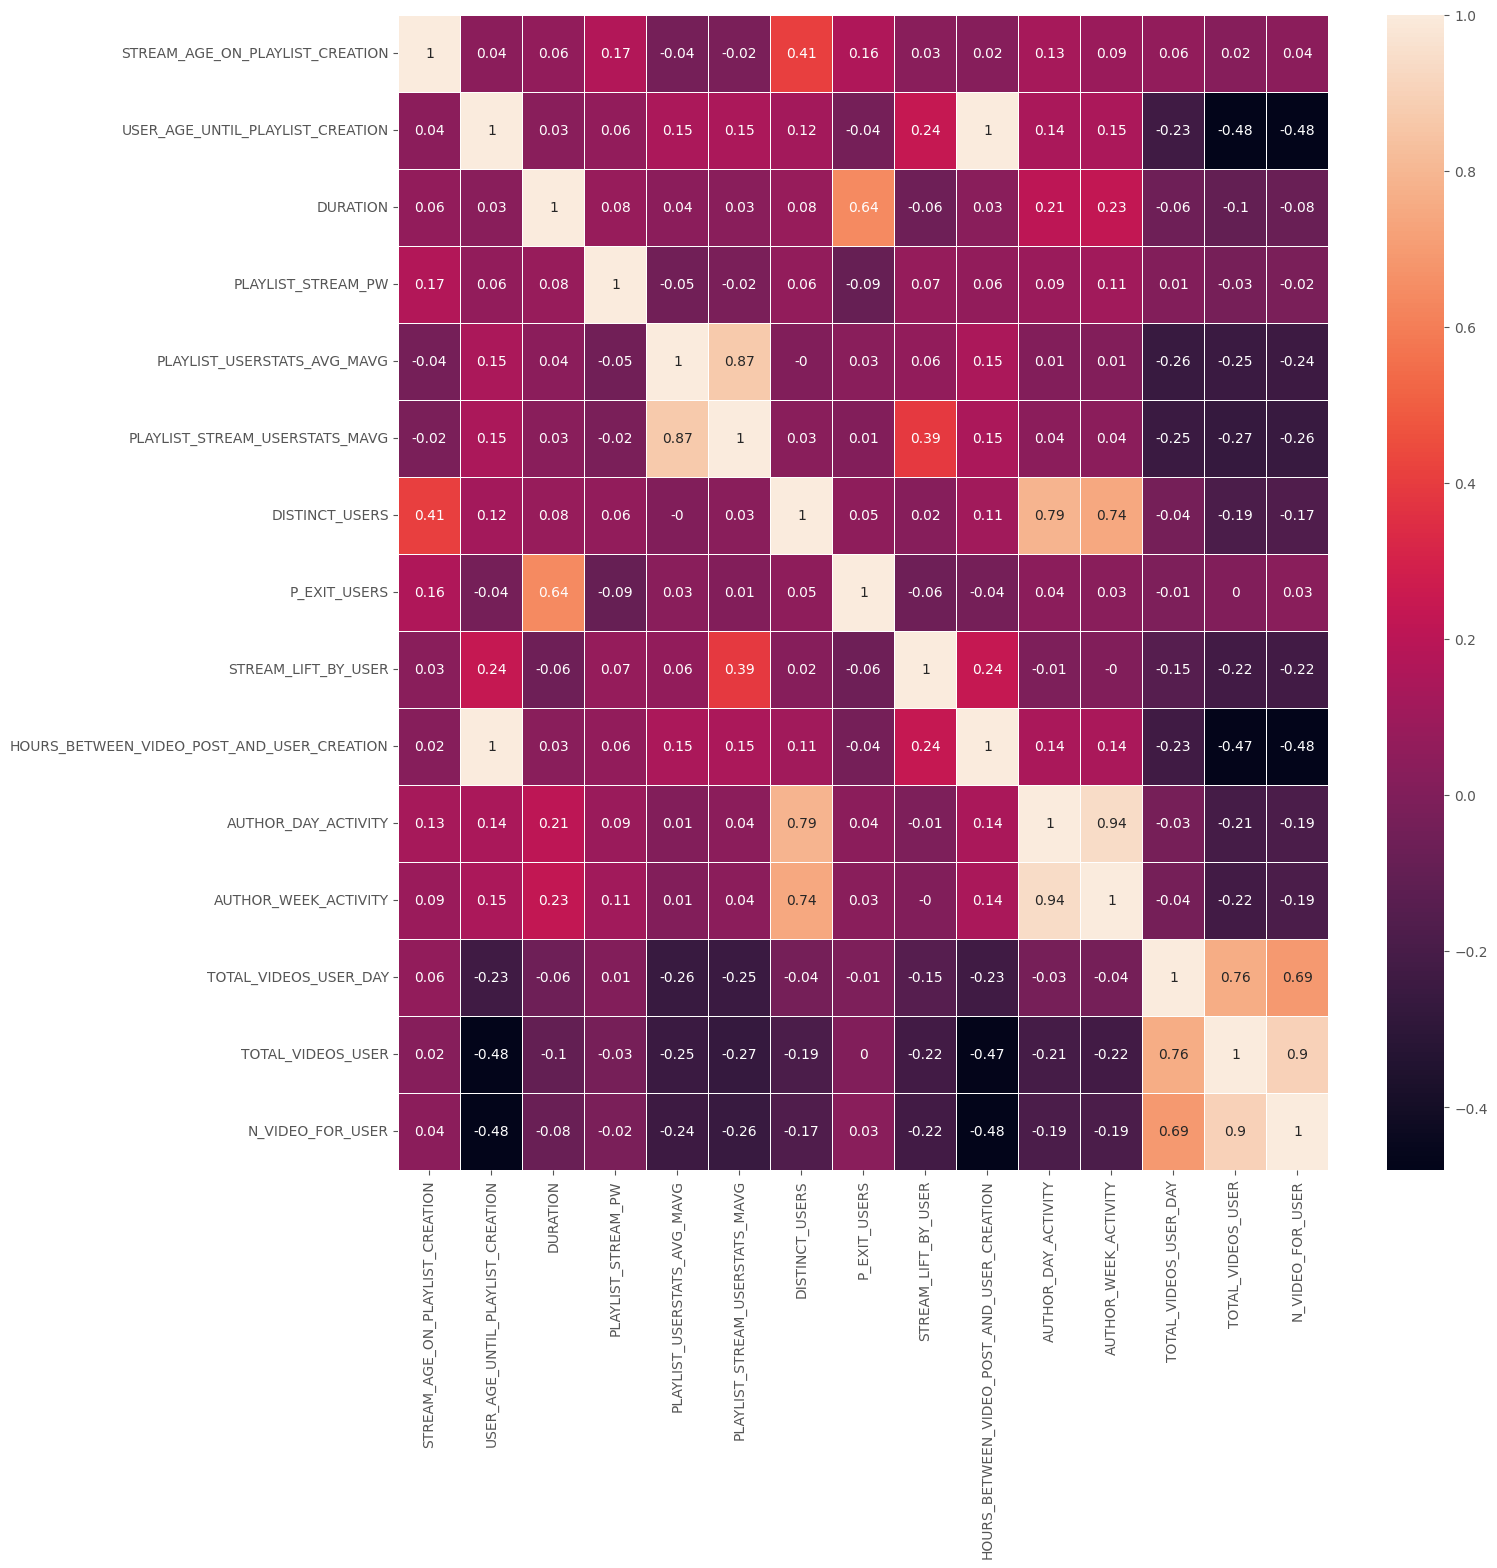

In [49]:
#Regenerating correlation matrix: We will drop PLAYLIST_STREAM_USERSTATS_MAVG, AUTHOR_WEEK_ACTIVITY & N_VIDEO_FOR_USER for dimensional reduction to avoid multi-collinearity
matrix=df_post_fe[inputs_num].corr(method='spearman').round(2)
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(matrix,annot=True,linewidths=.5, ax=ax)
plt.show()

In [50]:
inputs_num_reduced=['STREAM_AGE_ON_PLAYLIST_CREATION', 'USER_AGE_UNTIL_PLAYLIST_CREATION','DURATION','PLAYLIST_STREAM_PW',
       'PLAYLIST_USERSTATS_AVG_MAVG',
       'DISTINCT_USERS', 'P_EXIT_USERS', 'STREAM_LIFT_BY_USER',
       'HOURS_BETWEEN_VIDEO_POST_AND_USER_CREATION', 'AUTHOR_DAY_ACTIVITY','TOTAL_VIDEOS_USER_DAY',
       'TOTAL_VIDEOS_USER']

In [51]:
#Re-categorizing values into quartile bins
for i in inputs_num:
    
    q1 = np.nanpercentile(df_post_fe[i], 25)
    q2 = np.nanpercentile(df_post_fe[i], 50)
    q3 = np.nanpercentile(df_post_fe[i], 75)
    
   
    def categorize_value(x):
        if pd.isnull(x):
            return 'NULL_VALUE'
        elif x <= q1:
            return '<= 1st Quartile'
        elif q1 < x <= q2:
            return '1st-2nd Quartile'
        elif q2 < x <= q3:
            return '2nd-3rd Quartile'
        else:
            return '> 3rd Quartile'
    
    
    df_post_fe[i + '_CATEGORY'] = df_post_fe[i].apply(categorize_value)

In [52]:
df_post_fe.columns

Index(['ACTION', 'TITLE', 'DESCRIPTION', 'CLIENT_OS', 'CHANNEL_TYPE',
       'CREATED_AT', 'STREAM_URL', 'STREAM_AUTHOR',
       'STREAM_AGE_ON_PLAYLIST_CREATION', 'USER_AGE_UNTIL_PLAYLIST_CREATION',
       'DURATION', 'IS_FAVORITE_CHANNEL', 'IS_FAVORITE_TAG', 'LIKE', 'MONTH',
       'PLAYLIST_USERSTATS_AVG_MAVG_CATEGORY',
       'PLAYLIST_STREAM_USERSTATS_MAVG_CATEGORY', 'DISTINCT_USERS_CATEGORY',
       'P_EXIT_USERS_CATEGORY', 'STREAM_AGE_ON_PLAYLIST_CREATION_CATEGORY',
       'USER_AGE_UNTIL_PLAYLIST_CREATION_CATEGORY', 'DURATION_CATEGORY',
       'POSTED_AT', 'PLAYLIST_STREAM_PW', 'PLAYLIST_USERSTATS_AVG_MAVG',
       'PLAYLIST_STREAM_USERSTATS_MAVG', 'DISTINCT_USERS', 'P_EXIT_USERS',
       'STREAM_LIFT_BY_USER', 'HOURS_BETWEEN_VIDEO_POST_AND_USER_CREATION',
       'AUTHOR_DAY_ACTIVITY', 'AUTHOR_WEEK_ACTIVITY', 'USER_ID', 'HOUR',
       'DAY_OF_WEEK', 'TOTAL_VIDEOS_USER_DAY', 'TOTAL_VIDEOS_USER',
       'N_VIDEO_FOR_USER', 'PLAYLIST_STREAM_PW_CATEGORY',
       'STREAM_LIFT_BY_USE

In [53]:
inputs_cat_no_target=['CLIENT_OS', 'CHANNEL_TYPE','STREAM_AUTHOR','IS_FAVORITE_CHANNEL', 'IS_FAVORITE_TAG','PLAYLIST_USERSTATS_AVG_MAVG_CATEGORY',
       'PLAYLIST_STREAM_USERSTATS_MAVG_CATEGORY', 'DISTINCT_USERS_CATEGORY',
       'P_EXIT_USERS_CATEGORY', 'STREAM_AGE_ON_PLAYLIST_CREATION_CATEGORY',
       'USER_AGE_UNTIL_PLAYLIST_CREATION_CATEGORY', 'DURATION_CATEGORY','PLAYLIST_STREAM_PW_CATEGORY',
       'STREAM_LIFT_BY_USER_CATEGORY',
       'HOURS_BETWEEN_VIDEO_POST_AND_USER_CREATION_CATEGORY',
       'AUTHOR_DAY_ACTIVITY_CATEGORY', 'AUTHOR_WEEK_ACTIVITY_CATEGORY',
       'TOTAL_VIDEOS_USER_DAY_CATEGORY', 'TOTAL_VIDEOS_USER_CATEGORY',
       'N_VIDEO_FOR_USER_CATEGORY','HOUR', 'DAY_OF_WEEK']

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_19840\2587018754.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,5))


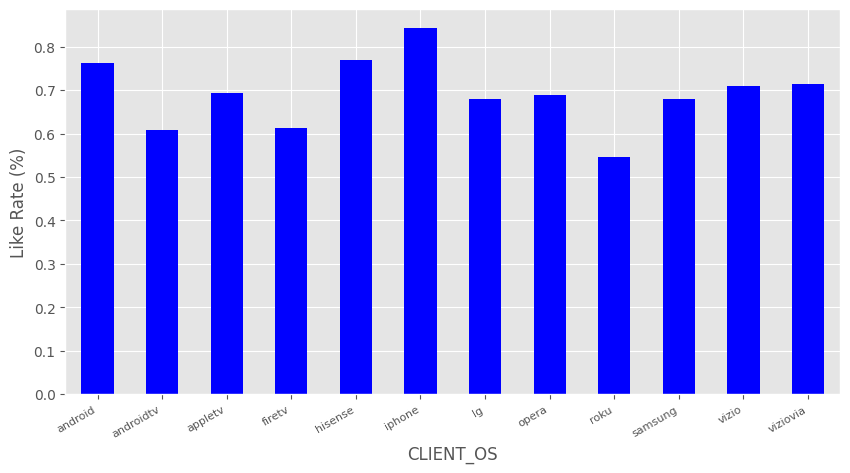

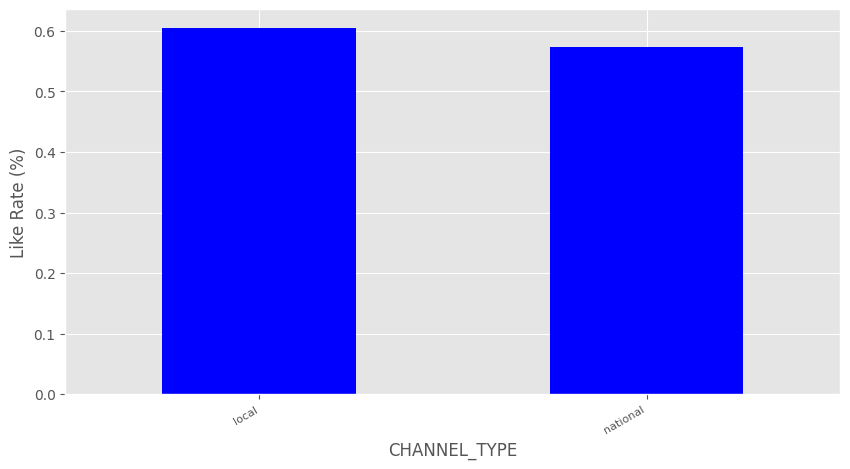

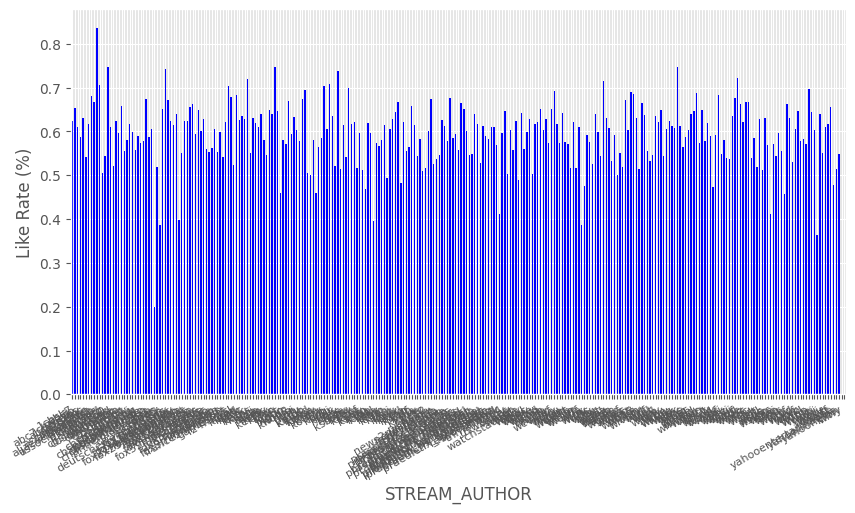

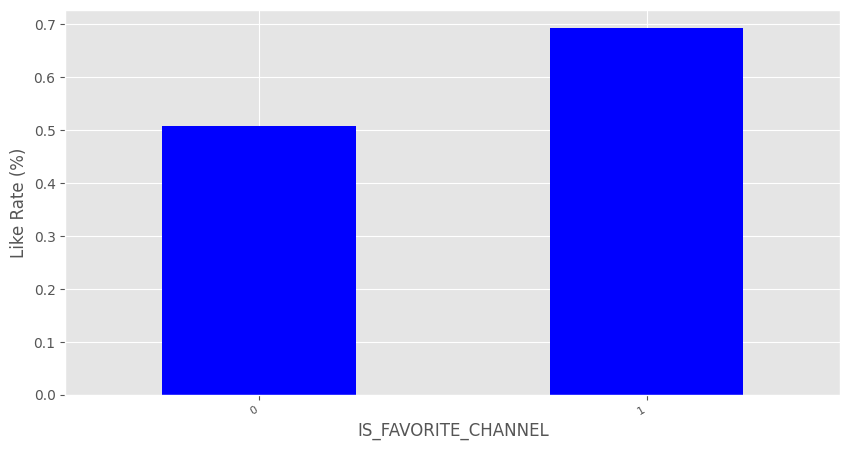

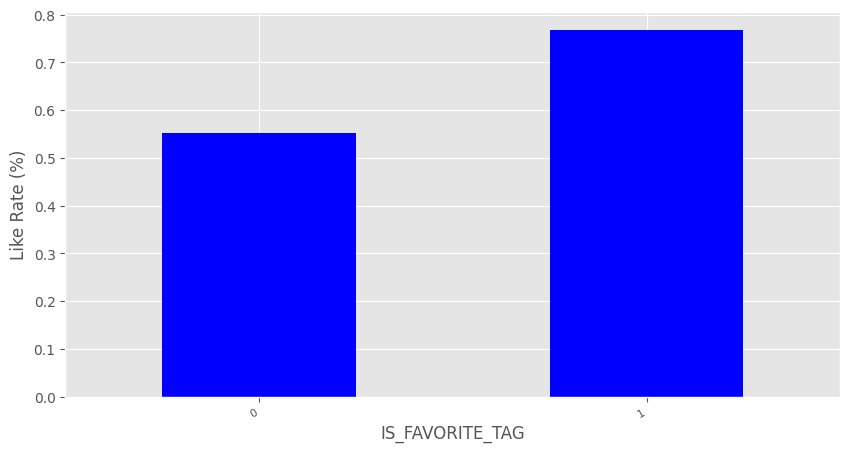

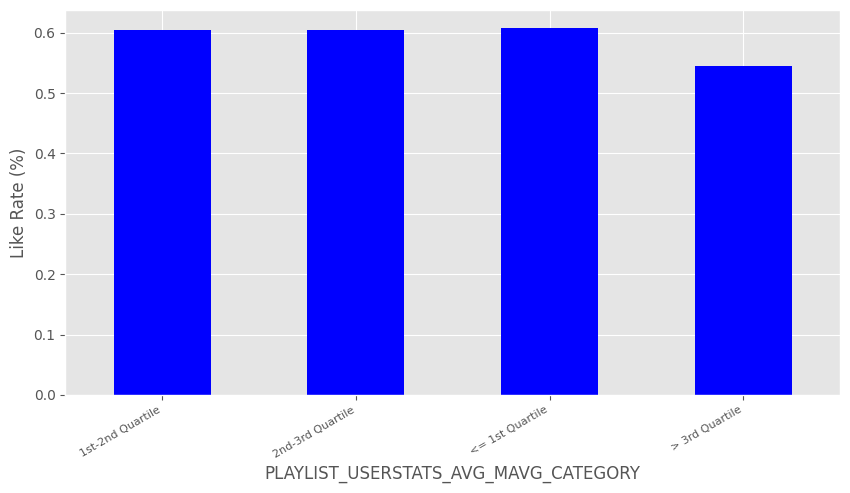

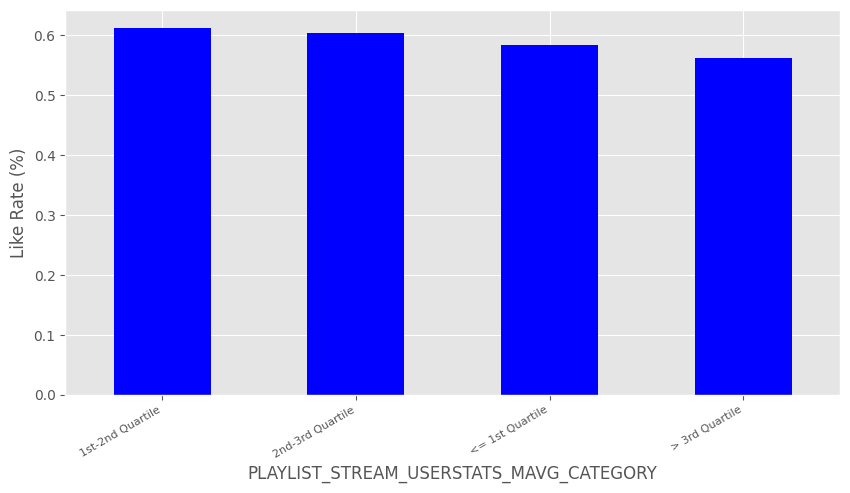

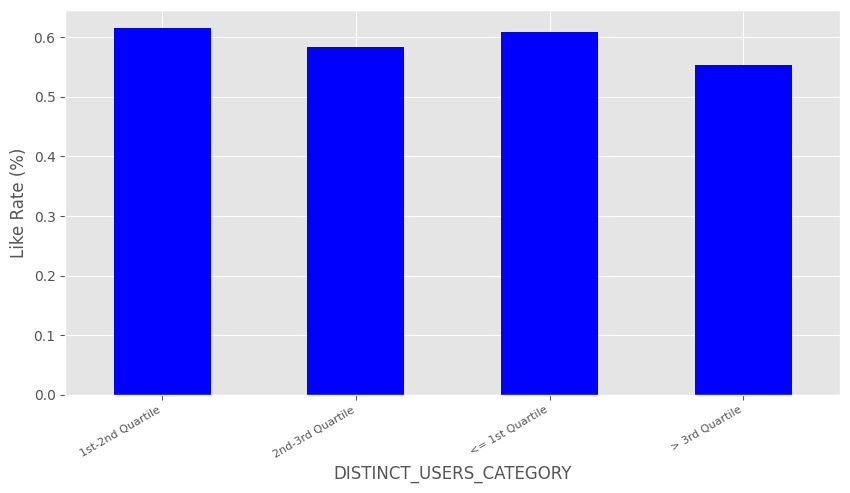

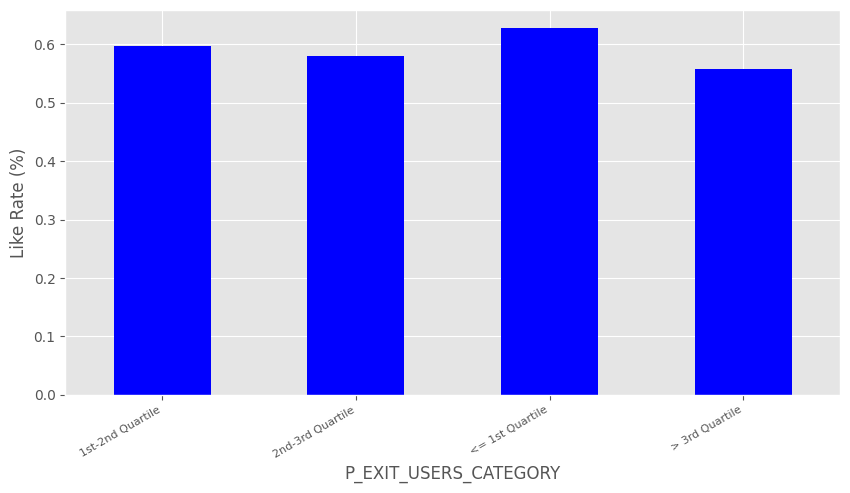

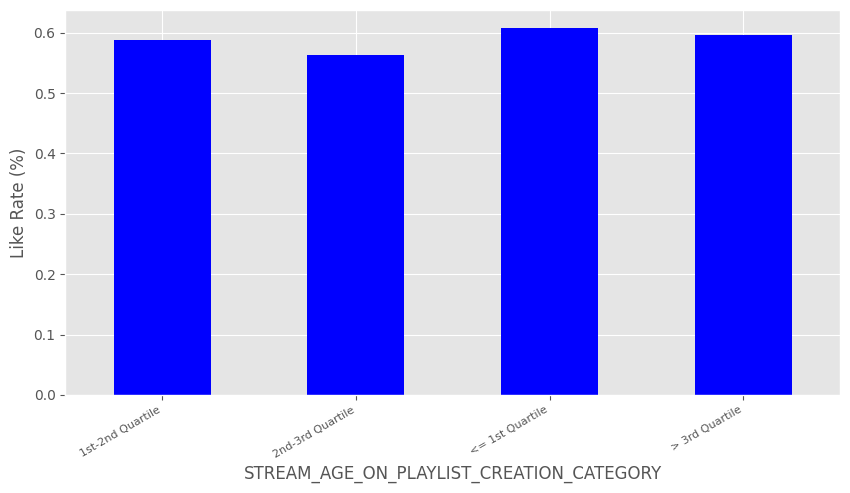

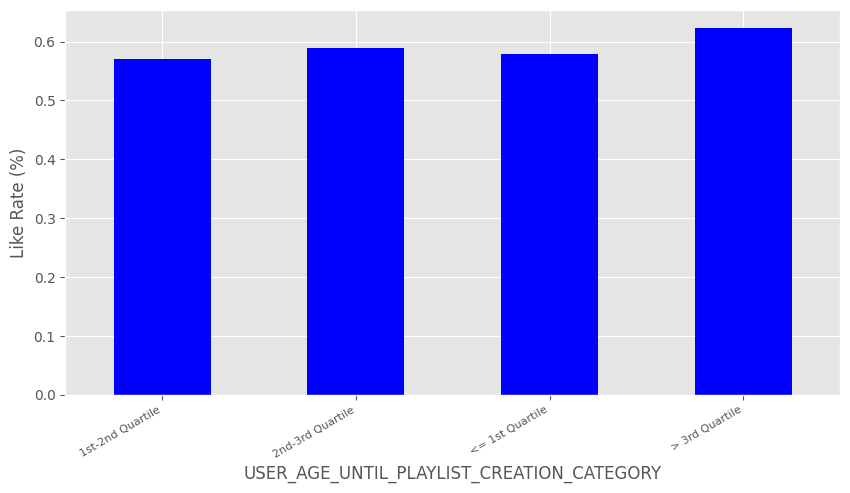

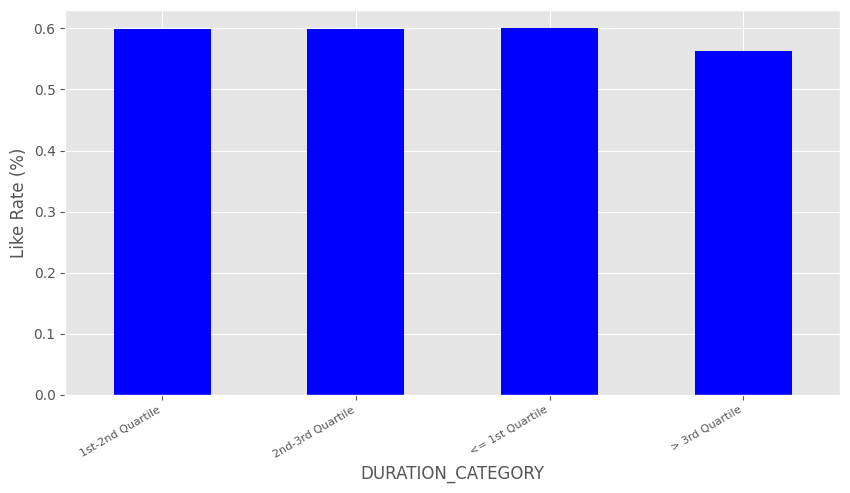

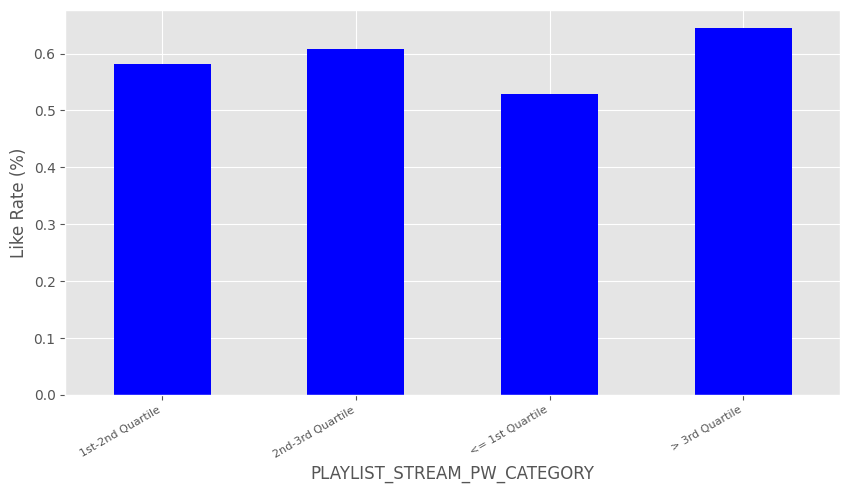

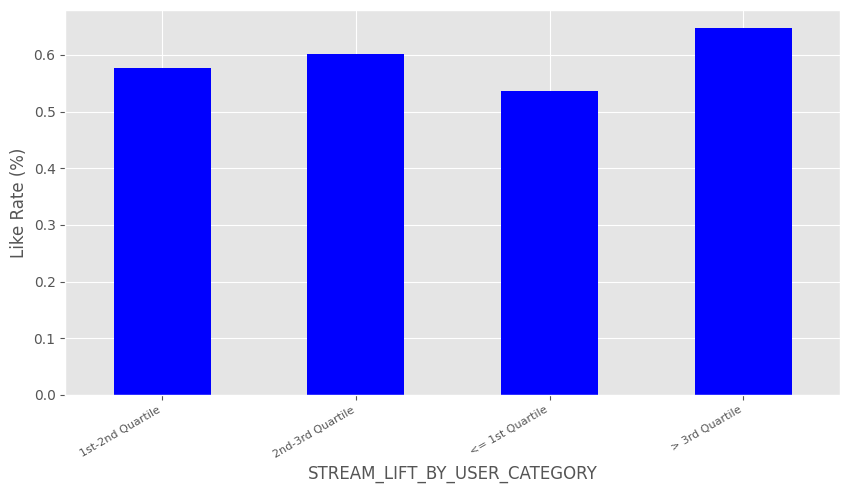

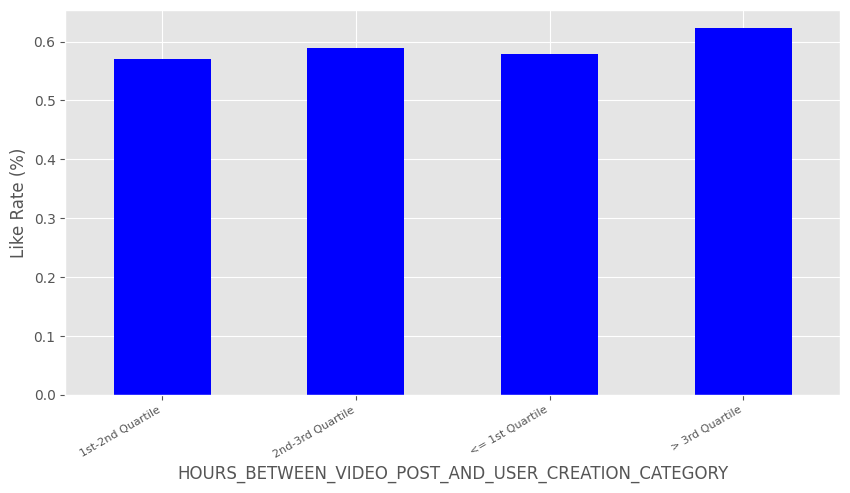

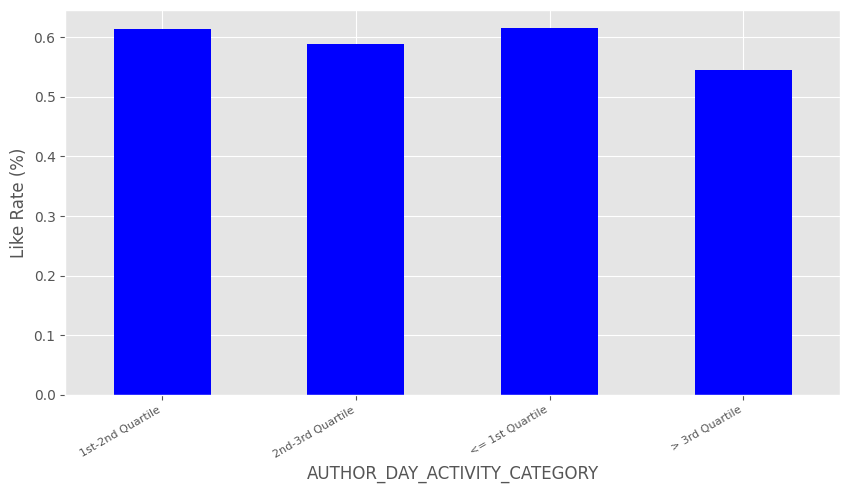

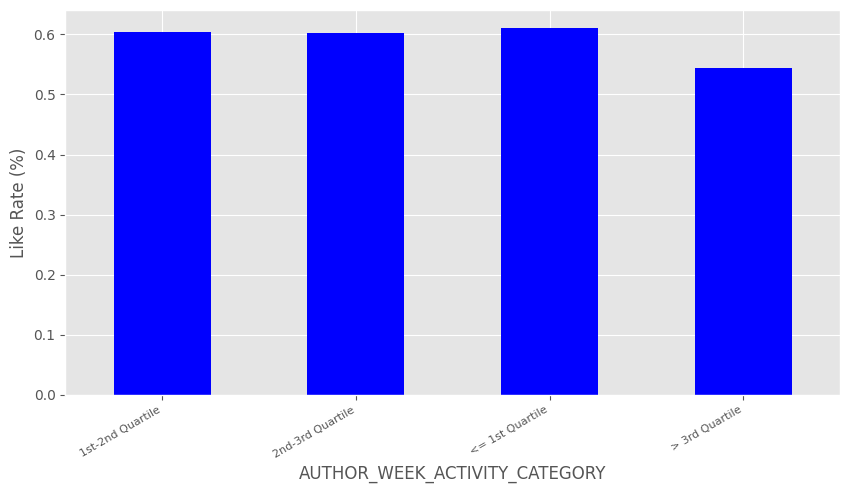

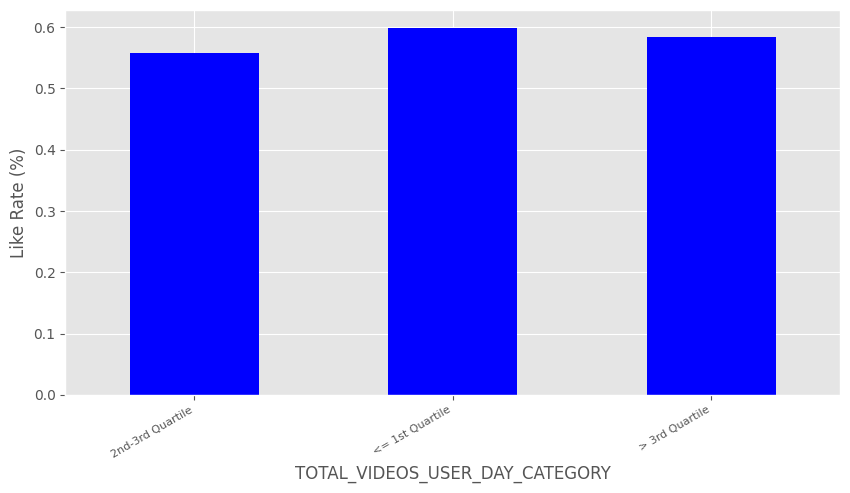

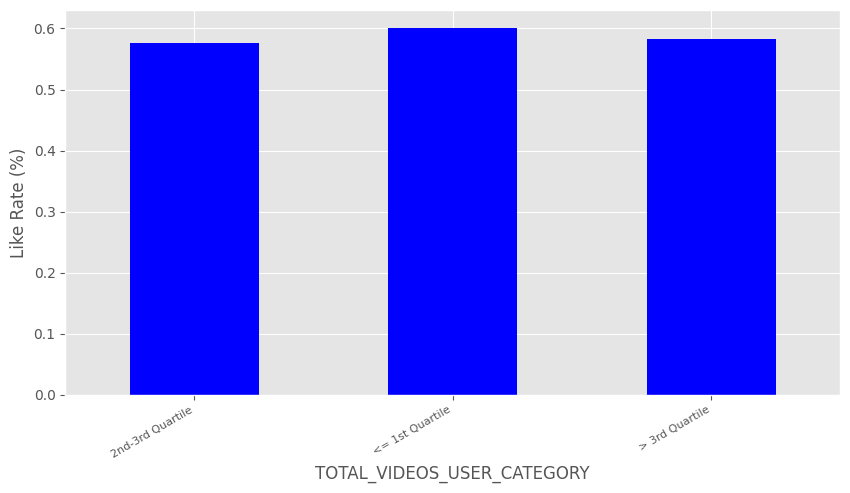

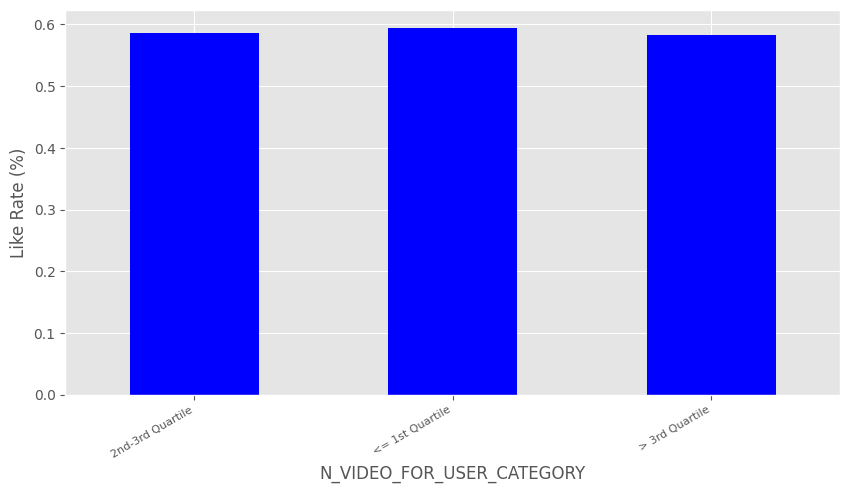

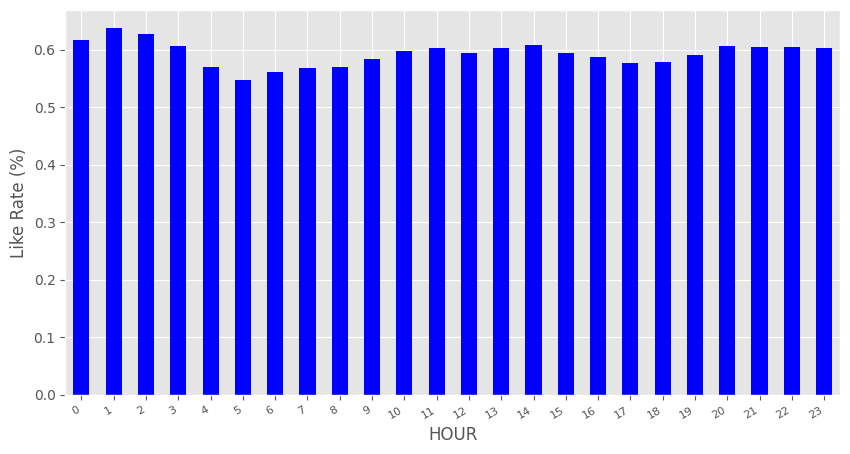

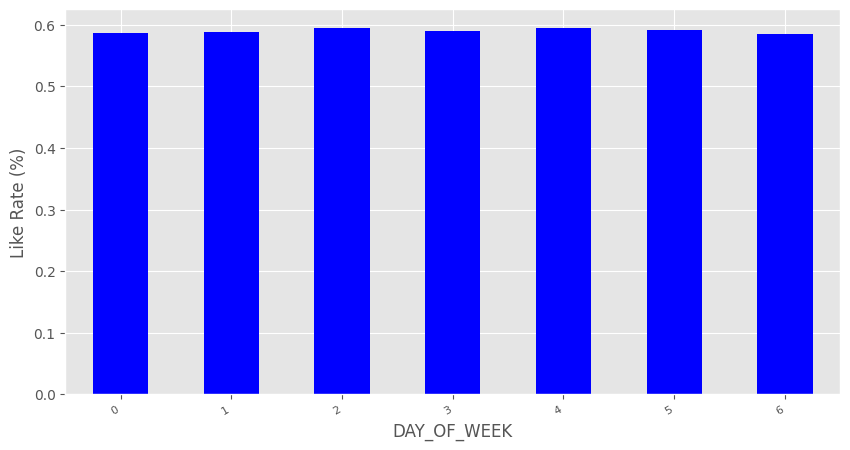

In [54]:
#After re-generating the bar charts (previously found OS & Favorite effects), there might also be an effect from Stream_Lift_by_User feature
for i in inputs_cat_no_target:
    resumen = pd.concat([df_post_fe[df_post_fe.LIKE == 0].groupby(i).LIKE.count()
                          , df_post_fe[df_post_fe.LIKE == 1].groupby(i).LIKE.count()], axis=1)
    resumen.columns = ['Dislike','Like']
    resumen_f = resumen.Like / (resumen.Like + resumen.Dislike)
    plt.figure(figsize=(10,5))
    ax = resumen_f.plot(kind = 'bar', color = 'b')
    ax.set_xticklabels(resumen_f.index, rotation=30, fontsize=8, ha='right')
    ax.set_xlabel(i)
    ax.set_ylabel('Like Rate (%)')

# CLIENT_OS EFFECT ANALYSIS
### In order to prove if difference in Like Rate % between platforms/devices is significant, a Chi-squared test will be helpful.
### If the p-value of the test falls below 0.05, the observed frequencies are significantly different from the expected frequencies and the null hypothesis can be rejected (H0= CLIENT_OS & LIKE RATE are independent).

In [55]:
#Apparently there is a difference in this rate for each device.
(df_post_fe.groupby('CLIENT_OS')['LIKE'].sum()/df_post_fe.groupby('CLIENT_OS')['CLIENT_OS'].count()).sort_values(ascending=False)

CLIENT_OS
iphone       0.843672
hisense      0.768473
android      0.761790
viziovia     0.714953
vizio        0.710510
appletv      0.693450
opera        0.688525
lg           0.680296
samsung      0.678929
firetv       0.612570
androidtv    0.608461
roku         0.546640
dtype: float64

In [56]:
b=df_post_fe['CLIENT_OS']
a=df_post_fe['LIKE']
df_os = pd.DataFrame({"like":a, 
                       "operative_system":b})

os_tab = pd.crosstab(df_os.like,df_os.operative_system, margins = True)
os_array = np.array(os_tab.iloc[0:2,0:12])
os_tab

operative_system,android,androidtv,appletv,firetv,hisense,iphone,lg,opera,roku,samsung,vizio,viziovia,All
like,,,,,,,,,,,,,
0,5440,5220,2705,13722,47,562,2854,38,103567,3107,3231,183,140676
1,17397,8112,6119,21696,156,3033,6073,84,124876,6570,7930,459,202505
All,22837,13332,8824,35418,203,3595,8927,122,228443,9677,11161,642,343181


In [57]:
os_array

array([[  5440,   5220,   2705,  13722,     47,    562,   2854,     38,
        103567,   3107,   3231,    183],
       [ 17397,   8112,   6119,  21696,    156,   3033,   6073,     84,
        124876,   6570,   7930,    459]], dtype=int64)

## P-value is lower than 0.05. Therefore, like rate (%) is not the same for each device.

In [58]:
stats.chi2_contingency(os_array)

Chi2ContingencyResult(statistic=7362.54178593328, pvalue=0.0, dof=11, expected_freq=array([[9.36129276e+03, 5.46502409e+03, 3.61711465e+03, 1.45184686e+04,
        8.32133131e+01, 1.47365449e+03, 3.65933619e+03, 5.00099714e+01,
        9.36428516e+04, 3.96677454e+03, 4.57509255e+03, 2.63167227e+02],
       [1.34757072e+04, 7.86697591e+03, 5.20688535e+03, 2.08995314e+04,
        1.19786687e+02, 2.12134551e+03, 5.26766381e+03, 7.19900286e+01,
        1.34800148e+05, 5.71022546e+03, 6.58590745e+03, 3.78832773e+02]]))

# Logistic Regression
## A logistic regression model will be used to determine the probability of liking a video, based on features studied above.

In [59]:
data=df_post_fe

In [60]:
inputs_num_reduced=['STREAM_AGE_ON_PLAYLIST_CREATION', 'USER_AGE_UNTIL_PLAYLIST_CREATION','DURATION',
       'DISTINCT_USERS', 'P_EXIT_USERS', 'STREAM_LIFT_BY_USER',
       'HOURS_BETWEEN_VIDEO_POST_AND_USER_CREATION', 'AUTHOR_DAY_ACTIVITY','TOTAL_VIDEOS_USER_DAY',
       'TOTAL_VIDEOS_USER']

In [61]:
from sklearn.preprocessing import StandardScaler

### Numerical features are now standardized as we need to avoid scale bias.

In [62]:
scaler = StandardScaler()

# Ajustar y transformar las columnas seleccionadas y reasignar a tu dataframe
data[inputs_num_reduced] = scaler.fit_transform(data[inputs_num_reduced])

In [63]:
data.head()

,ACTION,TITLE,DESCRIPTION,CLIENT_OS,CHANNEL_TYPE,CREATED_AT,STREAM_URL,STREAM_AUTHOR,STREAM_AGE_ON_PLAYLIST_CREATION,USER_AGE_UNTIL_PLAYLIST_CREATION,...,TOTAL_VIDEOS_USER,N_VIDEO_FOR_USER,PLAYLIST_STREAM_PW_CATEGORY,STREAM_LIFT_BY_USER_CATEGORY,HOURS_BETWEEN_VIDEO_POST_AND_USER_CREATION_CATEGORY,AUTHOR_DAY_ACTIVITY_CATEGORY,AUTHOR_WEEK_ACTIVITY_CATEGORY,TOTAL_VIDEOS_USER_DAY_CATEGORY,TOTAL_VIDEOS_USER_CATEGORY,N_VIDEO_FOR_USER_CATEGORY
0,LIKE,Iran disbands 'morality police' amid two and h...,<p>Iran’s Attorney General Mohammad Jafar Mont...,android,national,2022-12-04 15:59:06.780000-05:00,http://haystack.tv/id/OAzWaUKGm,euronews,-0.097915,-0.743654,...,-0.298140,1,<= 1st Quartile,> 3rd Quartile,1st-2nd Quartile,> 3rd Quartile,> 3rd Quartile,<= 1st Quartile,<= 1st Quartile,<= 1st Quartile
1,DISLIKE,"Were Humans in the Americans 20,000 Years Earl...",Archeologists from the U.S. and Mexico have fo...,android,national,2022-09-26 18:23:18.121000-05:00,http://haystack.tv/id/2XfkEuKw8,amazelab,1.718981,-0.743386,...,-0.297849,1,1st-2nd Quartile,> 3rd Quartile,1st-2nd Quartile,2nd-3rd Quartile,2nd-3rd Quartile,2nd-3rd Quartile,2nd-3rd Quartile,<= 1st Quartile
2,DISLIKE,Living Large: Luxury waterfront living can be ...,CBS4's Lisa Petrillo recently toured a palatia...,android,local,2022-09-26 18:27:34.240000-05:00,http://haystack.tv/id/OYG397Vox,cbsmiami,1.840920,-0.743386,...,-0.297849,2,2nd-3rd Quartile,> 3rd Quartile,1st-2nd Quartile,1st-2nd Quartile,2nd-3rd Quartile,2nd-3rd Quartile,2nd-3rd Quartile,2nd-3rd Quartile
3,LIKE,Bucha resident describes terrifying encounter ...,WARNING: This video contains graphic footage a...,android,national,2022-05-03 08:02:27.536000-05:00,http://haystack.tv/id/gxum5bcbf,cbcnews,-0.049140,-0.743386,...,-0.296977,1,> 3rd Quartile,> 3rd Quartile,1st-2nd Quartile,2nd-3rd Quartile,2nd-3rd Quartile,> 3rd Quartile,2nd-3rd Quartile,<= 1st Quartile
4,LIKE,Ukrainian circus performers who fled war take ...,Some have ended up at an international circus ...,android,national,2022-05-03 08:07:58.975000-05:00,http://haystack.tv/id/4aA0yOfgs,aljazeeraenglish,0.414230,-0.743386,...,-0.296977,2,2nd-3rd Quartile,> 3rd Quartile,1st-2nd Quartile,2nd-3rd Quartile,2nd-3rd Quartile,> 3rd Quartile,2nd-3rd Quartile,2nd-3rd Quartile


In [64]:
inputs_to_object=['HOUR','DAY_OF_WEEK']
for i in inputs_to_object:
    data[i]=data[i].astype(object)

In [65]:
#Categorial features need to be encoded to be able to proceed with the model
inputs_to_encode=['HOUR','DAY_OF_WEEK','CLIENT_OS','CHANNEL_TYPE','STREAM_AUTHOR']
data_dummies = pd.get_dummies(data[inputs_to_encode]).astype(int)
data_dummies.head()

,HOUR_0,HOUR_1,HOUR_2,HOUR_3,HOUR_4,HOUR_5,HOUR_6,HOUR_7,HOUR_8,HOUR_9,...,STREAM_AUTHOR_wwlp,STREAM_AUTHOR_wwti,STREAM_AUTHOR_wxii,STREAM_AUTHOR_wxmi,STREAM_AUTHOR_wxxv,STREAM_AUTHOR_wxyz,STREAM_AUTHOR_wyff,STREAM_AUTHOR_yahooentertainment,STREAM_AUTHOR_yahoofinance,STREAM_AUTHOR_yahoonews
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
data['HOUR'].value_counts()

HOUR
8     21613
9     20962
7     20407
18    19222
10    18762
19    18533
20    17834
17    17556
6     16874
21    16734
11    16640
22    15707
16    14869
12    14499
13    12963
15    12877
14    12692
23    11732
5     11576
0      8064
4      6932
1      6082
3      5078
2      4973
Name: count, dtype: int64

In [67]:
data['DAY_OF_WEEK'].value_counts()

DAY_OF_WEEK
0    52568
2    51881
1    50580
3    48853
6    47156
5    46280
4    45863
Name: count, dtype: int64

In [68]:
data['CLIENT_OS'].value_counts()

CLIENT_OS
roku         228443
firetv        35418
android       22837
androidtv     13332
vizio         11161
samsung        9677
lg             8927
appletv        8824
iphone         3595
viziovia        642
hisense         203
opera           122
Name: count, dtype: int64

In [69]:
data['CHANNEL_TYPE'].value_counts()

CHANNEL_TYPE
local       177428
national    165753
Name: count, dtype: int64

In [70]:
data['STREAM_AUTHOR'].value_counts()

STREAM_AUTHOR
abcnews       44138
newsyhub      20424
newsnation     9564
cnettv         9497
bloomberg      9223
              ...  
kxlh             26
chch             15
wwti             11
wlny              8
kron              3
Name: count, Length: 283, dtype: int64

In [71]:
data_dummies.shape[1]

328

In [72]:
#Removing least frequent values of each categorical feature encoded to prevent redundancy.
to_remove=['HOUR_2','STREAM_AUTHOR_kron','CHANNEL_TYPE_national','CLIENT_OS_opera','DAY_OF_WEEK_4']
data_dummies.drop(to_remove, inplace=True, axis=1)

In [73]:
y=data['LIKE']

In [74]:
inputs_previously_ready_num=['STREAM_AGE_ON_PLAYLIST_CREATION','USER_AGE_UNTIL_PLAYLIST_CREATION','DURATION',
       'DISTINCT_USERS', 'P_EXIT_USERS', 'STREAM_LIFT_BY_USER',
       'HOURS_BETWEEN_VIDEO_POST_AND_USER_CREATION', 'AUTHOR_DAY_ACTIVITY','TOTAL_VIDEOS_USER_DAY',
       'TOTAL_VIDEOS_USER']
inputs_previously_ready_cat=['IS_FAVORITE_CHANNEL', 'IS_FAVORITE_TAG']
x_num=data[inputs_previously_ready_num]
x_cat=pd.concat([data[inputs_previously_ready_cat], data_dummies], axis=1)
x_num.head()

,STREAM_AGE_ON_PLAYLIST_CREATION,USER_AGE_UNTIL_PLAYLIST_CREATION,DURATION,DISTINCT_USERS,P_EXIT_USERS,STREAM_LIFT_BY_USER,HOURS_BETWEEN_VIDEO_POST_AND_USER_CREATION,AUTHOR_DAY_ACTIVITY,TOTAL_VIDEOS_USER_DAY,TOTAL_VIDEOS_USER
0,-0.097915,-0.743654,-0.574396,2.305704,-0.412309,0.064802,-0.743007,0.477153,-0.328135,-0.298140
1,1.718981,-0.743386,-0.426802,0.800933,-0.403740,0.414663,-0.756076,-0.329807,-0.260799,-0.297849
2,1.840920,-0.743386,-0.074704,-0.303871,0.209661,0.099495,-0.756971,-0.552380,-0.260799,-0.297849
3,-0.049140,-0.743386,0.733350,-0.469179,0.531125,0.160651,-0.743097,-0.476537,-0.058794,-0.296977
4,0.414230,-0.743386,-0.146087,-0.000005,0.007304,0.056601,-0.746498,-0.331266,-0.058794,-0.296977


In [75]:
df=pd.concat([x_num,x_cat,y],axis=1)

In [76]:
df.head()

,STREAM_AGE_ON_PLAYLIST_CREATION,USER_AGE_UNTIL_PLAYLIST_CREATION,DURATION,DISTINCT_USERS,P_EXIT_USERS,STREAM_LIFT_BY_USER,HOURS_BETWEEN_VIDEO_POST_AND_USER_CREATION,AUTHOR_DAY_ACTIVITY,TOTAL_VIDEOS_USER_DAY,TOTAL_VIDEOS_USER,...,STREAM_AUTHOR_wwti,STREAM_AUTHOR_wxii,STREAM_AUTHOR_wxmi,STREAM_AUTHOR_wxxv,STREAM_AUTHOR_wxyz,STREAM_AUTHOR_wyff,STREAM_AUTHOR_yahooentertainment,STREAM_AUTHOR_yahoofinance,STREAM_AUTHOR_yahoonews,LIKE
0,-0.097915,-0.743654,-0.574396,2.305704,-0.412309,0.064802,-0.743007,0.477153,-0.328135,-0.298140,...,0,0,0,0,0,0,0,0,0,1
1,1.718981,-0.743386,-0.426802,0.800933,-0.403740,0.414663,-0.756076,-0.329807,-0.260799,-0.297849,...,0,0,0,0,0,0,0,0,0,0
2,1.840920,-0.743386,-0.074704,-0.303871,0.209661,0.099495,-0.756971,-0.552380,-0.260799,-0.297849,...,0,0,0,0,0,0,0,0,0,0
3,-0.049140,-0.743386,0.733350,-0.469179,0.531125,0.160651,-0.743097,-0.476537,-0.058794,-0.296977,...,0,0,0,0,0,0,0,0,0,1
4,0.414230,-0.743386,-0.146087,-0.000005,0.007304,0.056601,-0.746498,-0.331266,-0.058794,-0.296977,...,0,0,0,0,0,0,0,0,0,1


In [77]:
#Just in case, a VIF analysis can be helpful to prevent multi-collinearity.
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = df[inputs_previously_ready_num].columns
vif_data["VIF"] = [variance_inflation_factor(df[inputs_previously_ready_num].values, i) for i in range(df[inputs_previously_ready_num].shape[1])]

high_vif_features = vif_data[vif_data['VIF'] > 10].feature.tolist()
high_vif_features

C:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


['STREAM_AGE_ON_PLAYLIST_CREATION',
 'USER_AGE_UNTIL_PLAYLIST_CREATION',
 'HOURS_BETWEEN_VIDEO_POST_AND_USER_CREATION']

In [78]:
high_vif_features
#We can drop one of this features. Seems logical as HOURS_BETWEEN_VIDEO_POST_AND_USER_CREATION is the difference between the other 2 fields.

['STREAM_AGE_ON_PLAYLIST_CREATION',
 'USER_AGE_UNTIL_PLAYLIST_CREATION',
 'HOURS_BETWEEN_VIDEO_POST_AND_USER_CREATION']

In [79]:
df.drop('STREAM_AGE_ON_PLAYLIST_CREATION', inplace=True, axis=1)

In [80]:

y,X = dmatrices('LIKE ~ USER_AGE_UNTIL_PLAYLIST_CREATION + DISTINCT_USERS+P_EXIT_USERS+STREAM_LIFT_BY_USER+HOURS_BETWEEN_VIDEO_POST_AND_USER_CREATION+AUTHOR_DAY_ACTIVITY+TOTAL_VIDEOS_USER_DAY+TOTAL_VIDEOS_USER', data = df, return_type = 'dataframe')
y2,X2 = dmatrices('LIKE ~ IS_FAVORITE_CHANNEL+IS_FAVORITE_TAG+HOUR_0+HOUR_1+HOUR_3+HOUR_4+HOUR_5+HOUR_6+HOUR_7+HOUR_8+HOUR_9+HOUR_10+HOUR_11+HOUR_12+HOUR_13+HOUR_14+HOUR_15+HOUR_16+HOUR_17+HOUR_18+HOUR_19+HOUR_20+HOUR_21+HOUR_22+HOUR_23+DAY_OF_WEEK_0+DAY_OF_WEEK_1+DAY_OF_WEEK_2+DAY_OF_WEEK_3+DAY_OF_WEEK_5+DAY_OF_WEEK_6+CLIENT_OS_android+CLIENT_OS_androidtv+CLIENT_OS_appletv+CLIENT_OS_firetv+CLIENT_OS_hisense+CLIENT_OS_iphone+CLIENT_OS_lg+CLIENT_OS_roku+CLIENT_OS_samsung+CLIENT_OS_vizio+CLIENT_OS_viziovia+CHANNEL_TYPE_local', data = df, return_type = 'dataframe')


In [81]:
#We need to fit the logistic regression model to our data and generate the summary as output.
mod = sm.Logit(y,X)
mod2 = sm.Logit(y2,X2)
res = mod.fit()
res2 = mod2.fit()
res.summary()


Optimization terminated successfully.
         Current function value: 0.672965
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638253
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   LIKE   No. Observations:               343181
Model:                          Logit   Df Residuals:                   343172
Method:                           MLE   Df Model:                            8
Date:                Thu, 29 Feb 2024   Pseudo R-squ.:                0.005709
Time:                        00:26:32   Log-Likelihood:            -2.3095e+05
converged:                       True   LL-Null:                   -2.3227e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                      0.3670      0.003    105.274      0.000       0.360       0.374
USER_AGE_UNTIL_PLAYLIST_CREATION               1.7641      0.813      2.169      0.030       0.170       3.358
DISTINCT_USERS                                -0.0419      0.004    -10.802      0.000      -0.049      -0.034
P_EXIT_USERS                                  -0.0808      0.004    -22.630      0.000      -0.088      -0.074
STREAM_LIFT_BY_USER                            0.0456      0.004     11.523      0.000       0.038       0.053
HOURS_BETWEEN_VIDEO_POST_AND_USER_CREATION    -1.6697      0.813     -2.053      0.040      -3.263      -0.076
AUTHOR_DAY_ACTIVITY                           -0.0918      0.004    -23.824      0.000      -0.099      -0.084
TOTAL_VIDEOS_USER_DAY                          0.0197      0.007      2.901      0.004       0.006       0.033
TOTAL_VIDEOS_USER                             -0.0421      0.007     -6.120      0.000      -0.056      -0.029
==============================================================================================================
"""

In [82]:
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   LIKE   No. Observations:               343181
Model:                          Logit   Df Residuals:                   343137
Method:                           MLE   Df Model:                           43
Date:                Thu, 29 Feb 2024   Pseudo R-squ.:                 0.05699
Time:                        00:26:35   Log-Likelihood:            -2.1904e+05
converged:                       True   LL-Null:                   -2.3227e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.3722      0.203      1.830      0.067      -0.026       0.771
IS_FAVORITE_CHANNEL     0.6542      0.008     86.171      0.000       0.639       0.669
IS_FAVORITE_TAG         0.8384      0.011     76.425      0.000       0.817       0.860
HOUR_0                 -0.0322      0.039     -0.831      0.406      -0.108       0.044
HOUR_1                  0.0619      0.041      1.500      0.134      -0.019       0.143
HOUR_3                 -0.0773      0.043     -1.808      0.071      -0.161       0.007
HOUR_4                 -0.2223      0.040     -5.605      0.000      -0.300      -0.145
HOUR_5                 -0.3014      0.036     -8.326      0.000      -0.372      -0.230
HOUR_6                 -0.2366      0.035     -6.850      0.000      -0.304      -0.169
HOUR_7                 -0.2038      0.034     -6.014      0.000      -0.270      -0.137
HOUR_8                 -0.1925      0.034     -5.712      0.000      -0.259      -0.126
HOUR_9                 -0.1462      0.034     -4.321      0.000      -0.212      -0.080
HOUR_10                -0.1046      0.034     -3.056      0.002      -0.172      -0.038
HOUR_11                -0.0738      0.035     -2.128      0.033      -0.142      -0.006
HOUR_12                -0.1141      0.035     -3.239      0.001      -0.183      -0.045
HOUR_13                -0.0849      0.036     -2.374      0.018      -0.155      -0.015
HOUR_14                -0.0655      0.036     -1.823      0.068      -0.136       0.005
HOUR_15                -0.1140      0.036     -3.188      0.001      -0.184      -0.044
HOUR_16                -0.1149      0.035     -3.275      0.001      -0.184      -0.046
HOUR_17                -0.1566      0.034     -4.552      0.000      -0.224      -0.089
HOUR_18                -0.1503      0.034     -4.411      0.000      -0.217      -0.084
HOUR_19                -0.1037      0.034     -3.029      0.002      -0.171      -0.037
HOUR_20                -0.0494      0.034     -1.436      0.151      -0.117       0.018
HOUR_21                -0.0501      0.035     -1.446      0.148      -0.118       0.018
HOUR_22                -0.0499      0.035     -1.428      0.153      -0.118       0.019
HOUR_23                -0.0623      0.036     -1.718      0.086      -0.133       0.009
DAY_OF_WEEK_0          -0.0249      0.014     -1.844      0.065      -0.051       0.002
DAY_OF_WEEK_1          -0.0205      0.014     -1.503      0.133      -0.047       0.006
DAY_OF_WEEK_2          -0.0010      0.014     -0.076      0.939      -0.028       0.026
DAY_OF_WEEK_3          -0.0135      0.014     -0.984      0.325      -0.040       0.013
DAY_OF_WEEK_5          -0.0146      0.014     -1.043      0.297      -0.042       0.013
DAY_OF_WEEK_6          -0.0367      0.014     -2.650      0.008      -0.064      -0.010
CLIENT_OS_android       0.3512      0.201      1.744      0.081      -0.044       0.746
CLIENT_OS_androidtv    -0.4155      0.202     -2.060      0.039      -0.8

<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_19840\3047809888.py:2: SyntaxWarning: invalid escape sequence '\l'
  display.Image("C:\\JN\log_function.png")


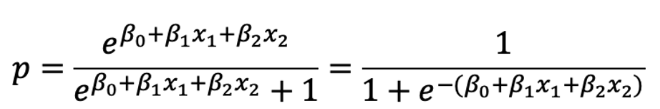

In [83]:
from IPython import display
display.Image("C:\\JN\log_function.png")


## Based on the logistic function:
### *Coefficients: Log odds of liking a video depending on each feature.
### *Std error: Typical deviation of log odds, which also influence the confidence interval.
### *P-value: If p-value is lower than 0.05, we conclude that the target and the feature are related and reject the null hypothesis.
### *Confidence Interval: Range of values we expect the coefficient to fall between. If 0 is not within the interval, it is significant. 

In [84]:
#We can create a new dataframe with the p-values for each feature

pvalues = pd.concat([res2.pvalues[1:].T.to_frame(),res.pvalues[1:].T.to_frame()], 
                   ignore_index=False)

pvalues.index.name = 'Features'
pvalues.reset_index()

,Features,0
0,IS_FAVORITE_CHANNEL,0.000000e+00
1,IS_FAVORITE_TAG,0.000000e+00
2,HOUR_0,4.060331e-01
3,HOUR_1,1.335064e-01
4,HOUR_3,7.060687e-02
5,HOUR_4,2.077554e-08
6,HOUR_5,8.337039e-17
7,HOUR_6,7.408903e-12
8,HOUR_7,1.812663e-09
9,HOUR_8,1.117848e-08


In [85]:
#We can create a new dataframe with the coefficientes for each feature

params = pd.concat([res2.params[1:].T.to_frame(),res.params[1:].T.to_frame()], 
                   ignore_index=False)

params.index.name = 'Features'
params.reset_index()

,Features,0
0,IS_FAVORITE_CHANNEL,0.654211
1,IS_FAVORITE_TAG,0.838396
2,HOUR_0,-0.032161
3,HOUR_1,0.061874
4,HOUR_3,-0.077342
5,HOUR_4,-0.222286
6,HOUR_5,-0.301356
7,HOUR_6,-0.236566
8,HOUR_7,-0.203753
9,HOUR_8,-0.192483


In [86]:
# Merging both and renaming them to display the results

model_results = pd.merge(params, pvalues, how = "left", on = "Features",suffixes=("params","pvalues")).fillna(0).reset_index()

model_results = model_results.rename(columns={'0params': 'Params', "0pvalues":'Pvalues'})
model_results

,Features,Params,Pvalues
0,IS_FAVORITE_CHANNEL,0.654211,0.000000e+00
1,IS_FAVORITE_TAG,0.838396,0.000000e+00
2,HOUR_0,-0.032161,4.060331e-01
3,HOUR_1,0.061874,1.335064e-01
4,HOUR_3,-0.077342,7.060687e-02
5,HOUR_4,-0.222286,2.077554e-08
6,HOUR_5,-0.301356,8.337039e-17
7,HOUR_6,-0.236566,7.408903e-12
8,HOUR_7,-0.203753,1.812663e-09
9,HOUR_8,-0.192483,1.117848e-08


In [87]:
#SNS Settings 
sns.set(color_codes = True)
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(10,10)})
sns.set_palette("Set3")

## The p-values chart will help us see which features are significant indeed (those that do not surpass the vertical line at 5%).

<Figure size 1500x1500 with 0 Axes>

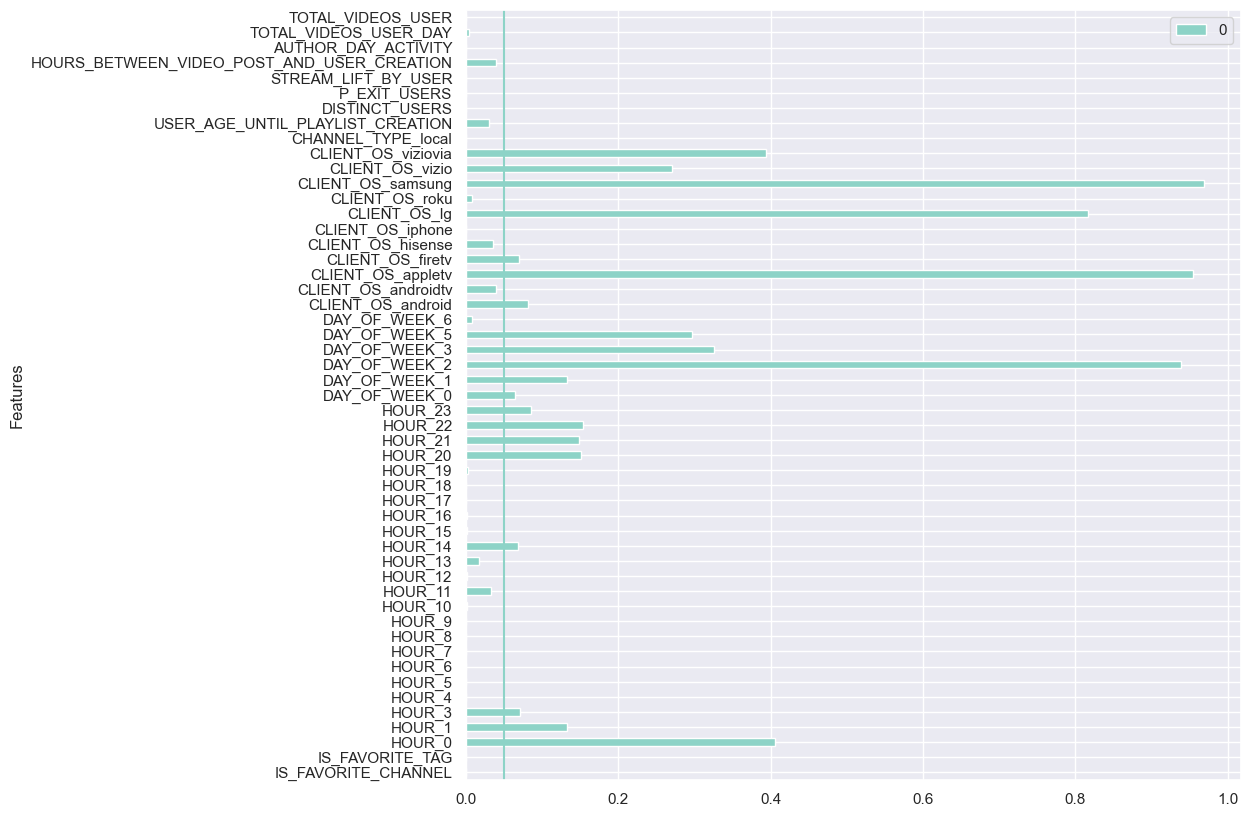

In [88]:
plt.figure(figsize=(15,15))

pvalues.plot.barh()
plt.axvline(x = 0.05)
plt.show();

## We can do the same for coefficients, in order to see which tend to have a negative effect on our target and which increase the odds to like a video.

<Axes: ylabel='Features'>

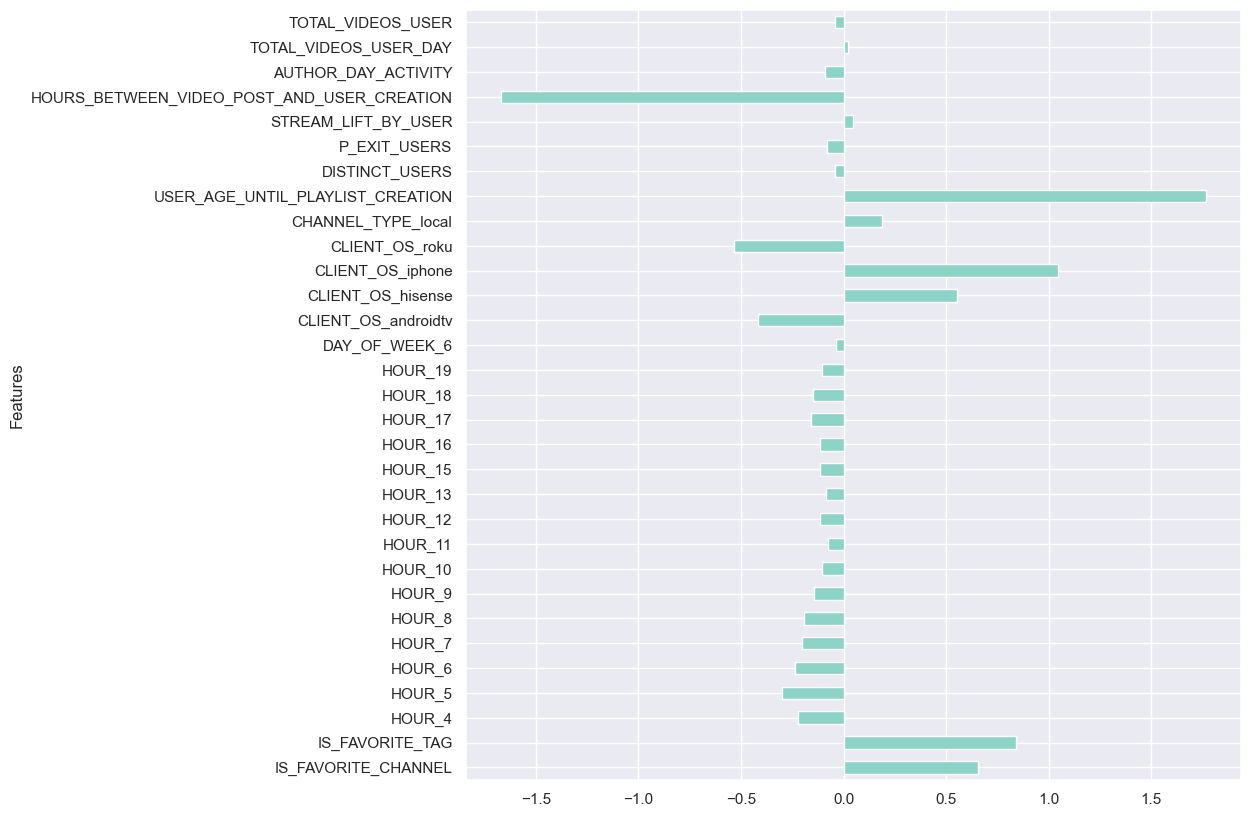

In [89]:
# charting coefficients
significant_results=model_results[model_results.Pvalues<=0.05]
significant_results = significant_results.set_index('Features')
significant_results.Params.plot.barh()

## By applying the exponential function to the coefficients, we obtain the odds ratio for each feature.

In [90]:
significant_results['Odds'] = np.exp(significant_results['Params'])
significant_results['Percent'] = (significant_results['Odds'] - 1)*100 

## The most significant features are:
### Positive effect:
### *USER_AGE_UNTIL_PLAYLIST_CREATION: Maturity and loyalty benefits the probability of liking a video by 483%.
### *CLIENT_OS_iphone: Iphone users show more engagement as it increases the odds of liking a video by 185%.
### *IS_FAVORITE_TAG & IS_FAVORITE_CHANNEL: If the video/channel is marked as favorite, it increases the odss of liking a video by 131% and 92%, respectively.
### *CLIENT_OS_hisense: Having a Hisense device increases the odds by 73%.
### *CHANNEL_TYPE_LOCAL: Watching a local news video increases the odds by 20%.
### *STREAM_LIFT_BY_USER: Having a history of opening more videos from a given channel increases the odds by 5%.
### Negative Effect:
### *HOURS_BETWEEN_VIDEO_POST_AND_USER_CREATION: The less recent the video is for the user (greater value of the feature), the lower the probability of liking a video by -81%.
### *ROKU & Android TV: Both reduce the odds by -41% and -33%, respectively.
### *Hours within the day: There are certain hours within the day that tend to have a lower probability of liking a video (more detail below).

In [91]:
significant_results.sort_values(by=['Odds'], ascending=False)

,Params,Pvalues,Odds,Percent
Features,,,,
USER_AGE_UNTIL_PLAYLIST_CREATION,1.764078,3.004736e-02,5.836188,483.618782
CLIENT_OS_iphone,1.047330,3.757756e-07,2.850031,185.003143
IS_FAVORITE_TAG,0.838396,0.000000e+00,2.312654,131.265439
IS_FAVORITE_CHANNEL,0.654211,0.000000e+00,1.923624,92.362392
CLIENT_OS_hisense,0.552995,3.516804e-02,1.738451,73.845104
CHANNEL_TYPE_local,0.184885,1.022892e-131,1.203081,20.308059
STREAM_LIFT_BY_USER,0.045565,1.015494e-30,1.046619,4.661939
TOTAL_VIDEOS_USER_DAY,0.019659,3.714767e-03,1.019853,1.985311
DAY_OF_WEEK_6,-0.036725,8.060117e-03,0.963941,-3.605901
